In [66]:
import autograd.numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import seaborn
import time
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.figsize'] = 16, 9
mpl.rcParams['figure.dpi'] = 400


# Example, Simple Linear Model

In [114]:
def linear_model(x, weights):
    return weights[0] + np.sum(x*weights[1:])

xSet = [rnd.normal(size = 4) for i in xrange(50)]


optw = rnd.randint(-10, 10, size = 5).astype('float64')
ySet = np.array([linear_model(x, optw) for x in xSet]) + rnd.normal(size = len(xSet))
print(optw)

[-2.  4.  3.  7.  1.]


In [115]:
S = zip(xSet, ySet)

In [116]:
S[:6]

[(array([ 0.519454  , -1.14327907, -0.67807855,  1.08223409]),
  -7.5853031346346507),
 (array([-0.40975192,  1.22577174,  0.15768734, -0.64936755]),
  0.26820849423556914),
 (array([-0.0388918 ,  1.86924654,  0.77892099,  0.53744256]),
  9.9514635792811088),
 (array([-0.97979518, -0.85578712,  0.46630842, -1.1168617 ]),
  -6.5619324767912088),
 (array([ 0.81685154,  0.89199032,  1.46044686,  0.26865738]),
  14.571913703393843),
 (array([-0.38176536, -0.11149928, -1.21021535,  0.3277016 ]),
  -10.611876275552969)]

In [117]:
theta = rnd.randint(-10, 10, size = 5) + rnd.normal(size = 5)
# At first sight, we can go with a simple for loop over all samples - but this is not the most effcient way:
# we should use the dot product between the data matrix and the weight in this simple case
predictedY = [linear_model(x, theta) for x in xSet]
# Print the error
print np.sum((predictedY - ySet)**2)

15356.6758927


In [118]:
# The objective function measures the error of our prediction for a given sample set S
def objective_function(theta, S):
    return np.sum([(linear_model(x, theta) - y)**2 for x,y in S]) # + np.sqrt(np.sum(w**2))

# The objective function measures the error of our prediction for a given sample set S
def objective_function(theta, S):
    error = 0.
    for x,y in S:
        error += (linear_model(x, theta) - y)**2
    return error

# evaluate the error on a random guess
objective_function(theta, S)

15356.675892691163

In [119]:
def objective_function_gradient_2(theta, S):
    gradient = np.zeros_like(theta)
    for x,y in S:
        _x = np.append(1, x)
        gradient += 2 * _x * (linear_model(x, theta) - y)
    return gradient


# Manual Differentiation
# Ex  = (f(x,w) - y)^2 = f(x,w)^2 - 2*f(x,w)*y + y^2
# Ex/dw = (f(x,w)^2 - 2*f(x,w)*y)/dw    | f(x) = g(h(x)) =>  f'(x) = g'(h(x))h'(x)
#       = 2 * f(x,w) * (f(x,w)/dw) - 2*(f(x,w)/dw)*y
#   where 
#     f(x,w)/dw = (1, x_1, ... x_d)
def objective_function_gradient(theta, S):
    return np.sum([2*(linear_model(x, theta)*np.append(1, x)) - 
                   2* np.append(1, x)*y for x,y in S], axis = 0)


    
# Automatic Differentiation !
from autograd import grad
objective_function_gradient_auto = grad(objective_function)

In [120]:
print objective_function_gradient(theta, S)
print objective_function_gradient_2(theta, S)
print objective_function_gradient_auto(theta, S)

[  940.23651177   245.92344784  -194.49272334 -1375.35271428   -47.44341997]
[  940.23651177   245.92344784  -194.49272334 -1375.35271428   -47.44341997]
[  940.23651177   245.92344784  -194.49272334 -1375.35271428   -47.44341997]


In [121]:
# There is however a disatvantage:
%timeit objective_function_gradient(theta, S)
%timeit objective_function_gradient_auto(theta, S)

100 loops, best of 3: 3.15 ms per loop
10 loops, best of 3: 23.1 ms per loop


# Gradient Descent

In [122]:
def show_curves(curves, exclude = [], include = None):
    if (include is None):
        include = curves.keys()
    f, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10, 5))
    subset = [key for key in curves.keys() 
                  if (key not in exclude)]
    for k in subset:
        axes[0].plot(np.log10(curves[k]['error']))
        axes[0].set_ylabel('log10 Error on training data')
        axes[0].set_xlabel('Iteration')
        axes[1].plot(np.log10(curves[k]['gradnorm']))
        axes[1].set_ylabel('log10 gradient norm')
        axes[1].set_xlabel('Iteration')
    axes[0].legend(subset, loc='upper left')
    plt.show()

In [123]:
curves = dict()

## Batch Gradient Descent

Batch Gradient Descent takes all data into consideration

In [124]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradientNorm = list()
gradient_fun = objective_function_gradient
learningRate = 0.001
maxIter = 1000

t = time.time()
condition = True
niter = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta, S)
    theta -= learningRate*gradient
    niter += 1
    error.append(objective_function(theta, S))
    gradientNorm.append(np.linalg.norm(gradient))
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))
curves['gd-batch'] = {'error' : error, 'gradnorm': gradientNorm}

Computed 319 iterations in 1.54099988937 seconds.


In [125]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))

[-1.8330336   4.1830999   3.19576456  6.7639907   0.98641643]
[-2.  4.  3.  7.  1.]
Objective at theta 30.609389 and at orginal weights 36.399658
Gradient at theta: 0.0000000092353847


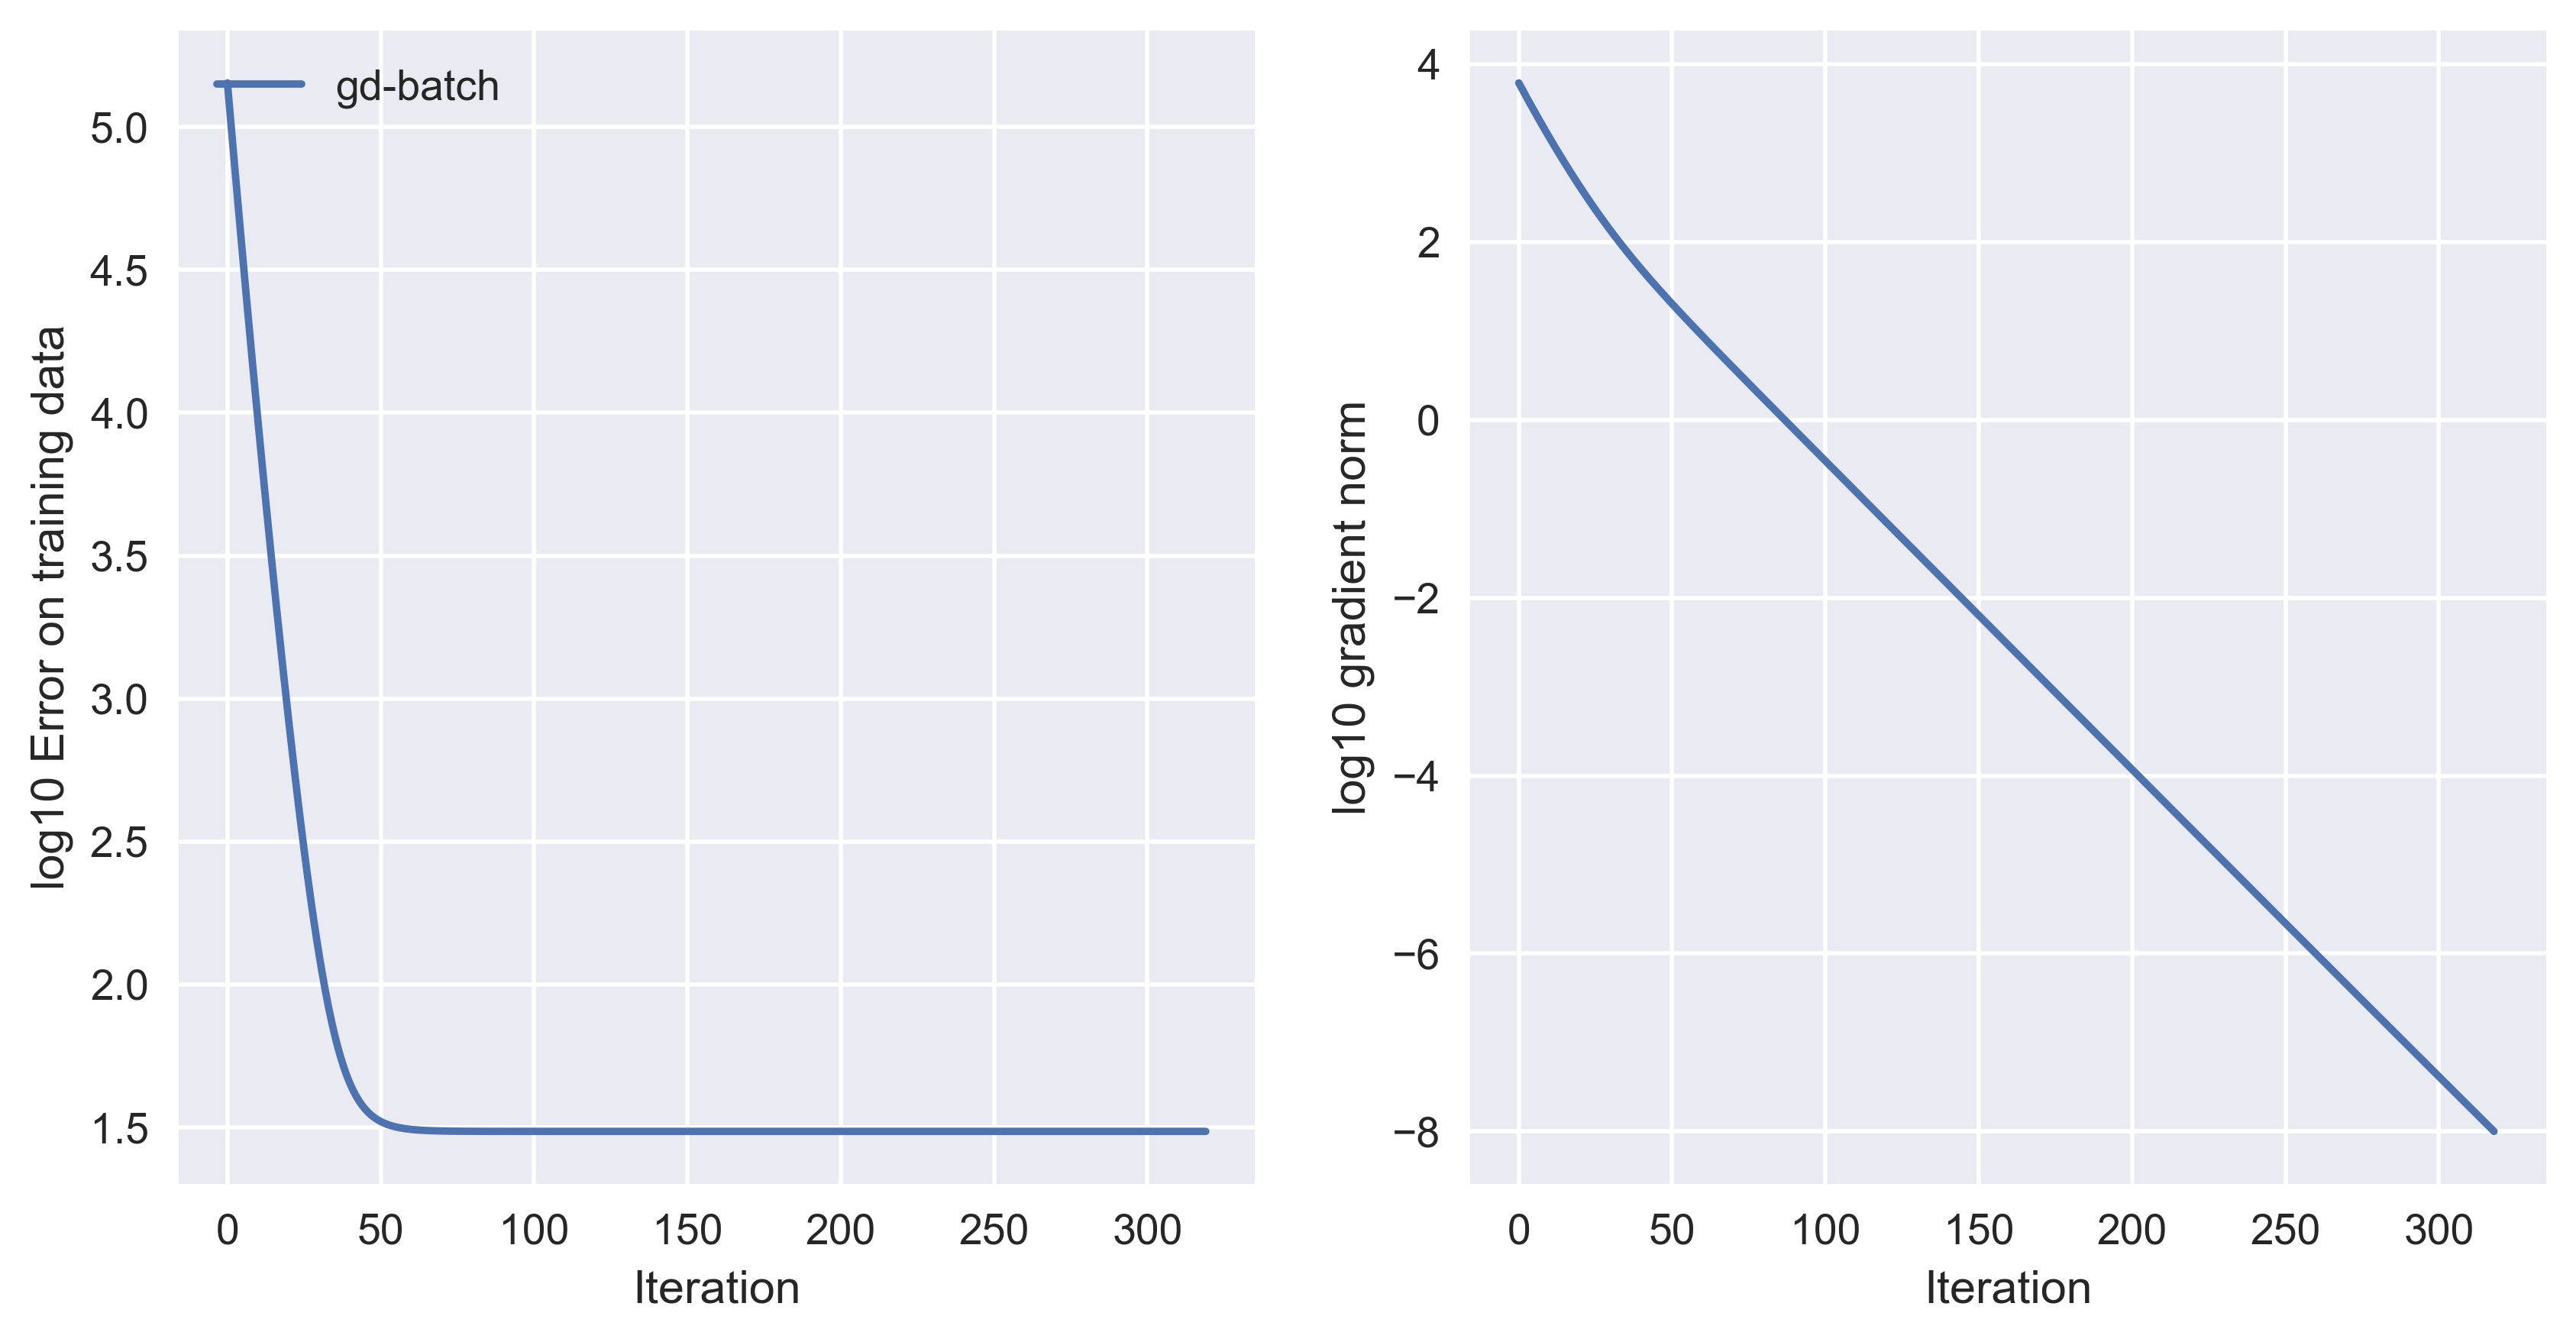

In [126]:
# f, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10, 5))
# axes[0].plot(np.log(curves['gd-batch']['error']))
# axes[0].set_ylabel('log10 Error on training data')
# axes[0].set_xlabel('Iteration')
# axes[1].plot(np.log(curves['gd-batch']['gradnorm']))
# axes[1].set_ylabel('log10 Norm of the gradient')
# axes[1].set_xlabel('Iteration')
# plt.show()
show_curves(curves)

## Stochastic gradient descent 

Stochastic Gradient Descent takes only single samples when computing gradients. The norm of the gradient will like not be zero when checking terminal condition.

In [127]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
localerror = list()
gradientNorm = list()
gradient_fun = objective_function_gradient
learningRate = 0.001
maxIter = 350

t = time.time()
condition = True
niter = 0
while condition:
    for j in xrange(len(S)):
        _S = S[j:j+1]
        gradient = gradient_fun(theta, _S)
        theta -= learningRate*gradient
        localerror.append(objective_function(theta, _S))
    error.append(objective_function(theta, S))
    gradientNorm.append(np.linalg.norm(gradient))
    niter += 1
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))
curves['gd-stochastic'] = {'error' : error, 'localerror': localerror, 'gradnorm': gradientNorm}

Computed 351 iterations in 2.61999988556 seconds.


In [128]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
# plt.plot(np.log10(curves['gd-stochastic']['localerror']))
plt.show()

[-1.82931098  4.18535457  3.19586874  6.77080283  0.99094111]
[-2.  4.  3.  7.  1.]
Objective at theta 30.614739 and at orginal weights 36.399658
Gradient at theta: 1.1894649689660191


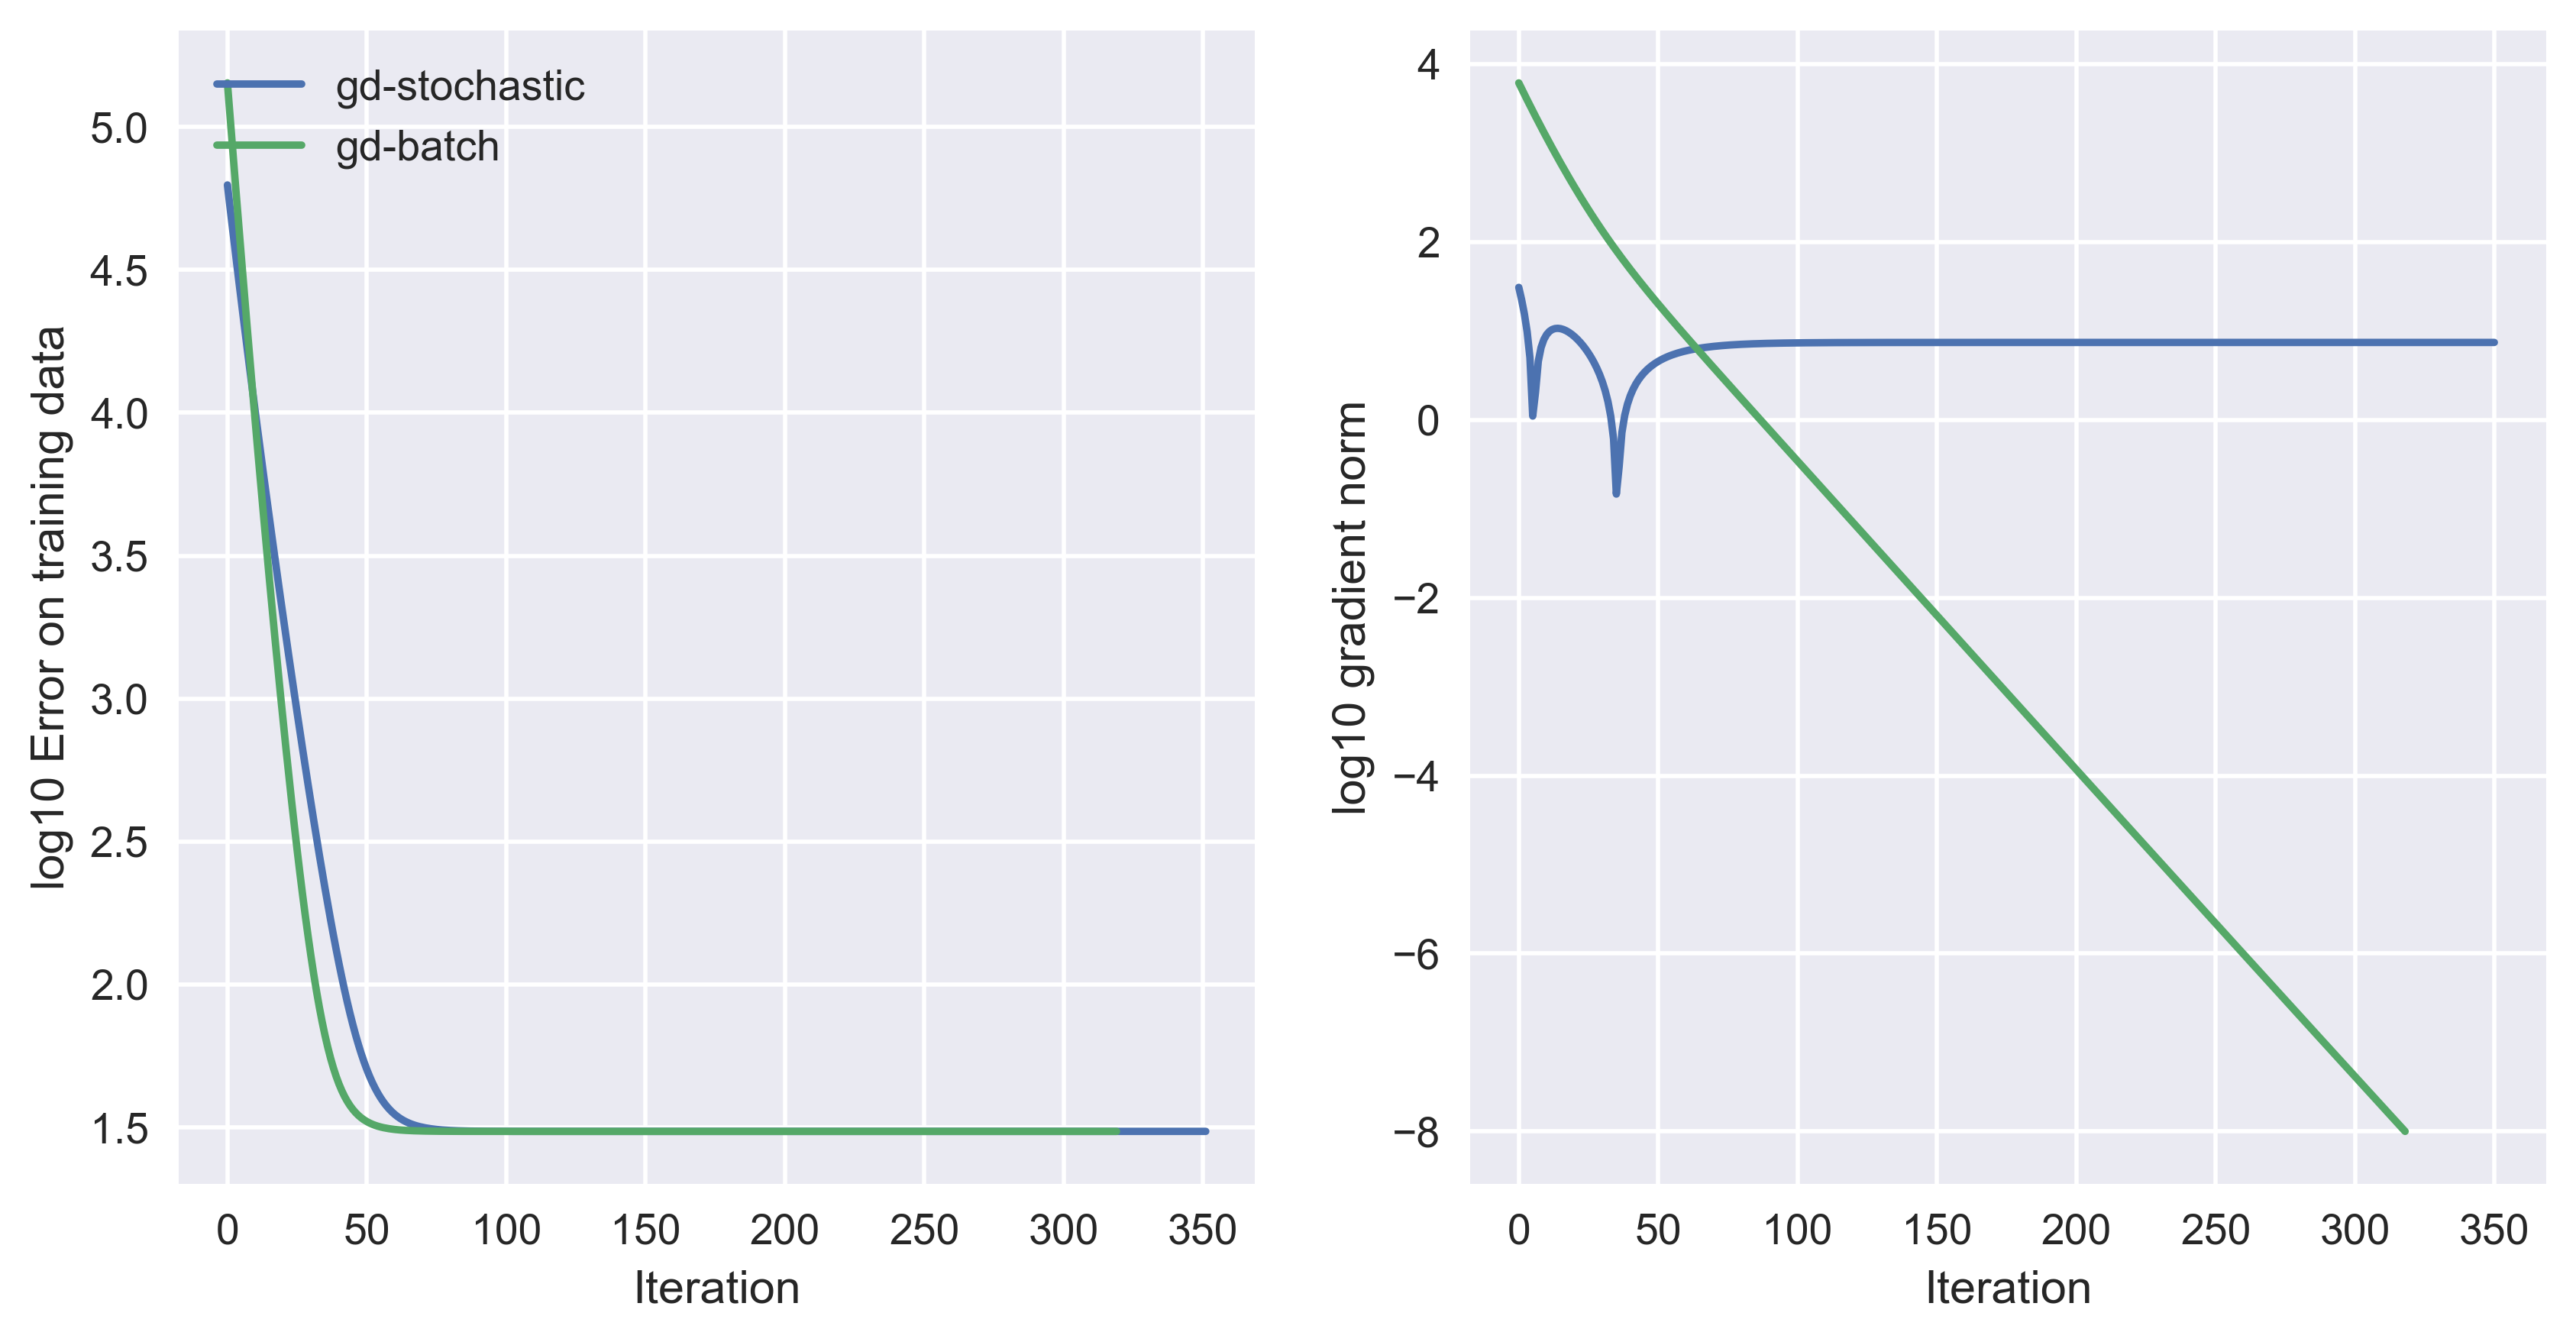

In [129]:
# f, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10, 5))
# axes[0].plot(np.log10(curves['gd-batch']['error']))
# axes[0].plot(np.log10(curves['gd-stochastic']['error']))
# axes[0].set_ylabel('log10 Error on training data')
# axes[0].set_xlabel('Iteration')
# axes[1].plot(np.log10(curves['gd-batch']['gradnorm']))
# axes[1].plot(np.log10(curves['gd-stochastic']['gradnorm']))
# axes[1].set_ylabel('log10 Norm of the gradient')
# axes[1].set_xlabel('Iteration')
# plt.show()
show_curves(curves)

## Mini-Batch Gradient Descent

This methods only considers small batches of data. The term epoch refers to the number of time whole dataset has been seen.

In [130]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
localerror = list()
gradientNorm = list()
gradient_fun = objective_function_gradient
learningRate = 0.001
batchSize = 32
maxIter = 100

t = time.time()
for epoch in xrange(350):
    mu = learningRate/(1+0.005*epoch)
    rnd.shuffle(S)    
    batches = [S[i:i + batchSize] for i in xrange(0, len(S), batchSize)]
    for _S in batches:
        gradient = gradient_fun(theta, _S)
        theta -= mu*gradient
        localerror.append(objective_function(theta, _S))
    error.append(objective_function(theta, S))
    gradientNorm.append(np.linalg.norm(gradient))

print 'Computed in %s seconds' % (time.time() - t)
curves['gd-minibatch'] = {'error' : error, 'localerror': localerror, 'gradnorm': gradientNorm}

Computed in 1.91799998283 seconds


[-1.83279869  4.18299767  3.19551494  6.76407558  0.9859015 ]
[-2.  4.  3.  7.  1.]
Objective at theta 30.609417 and at orginal weights 36.399658
Gradient at theta: 0.0908390025843011


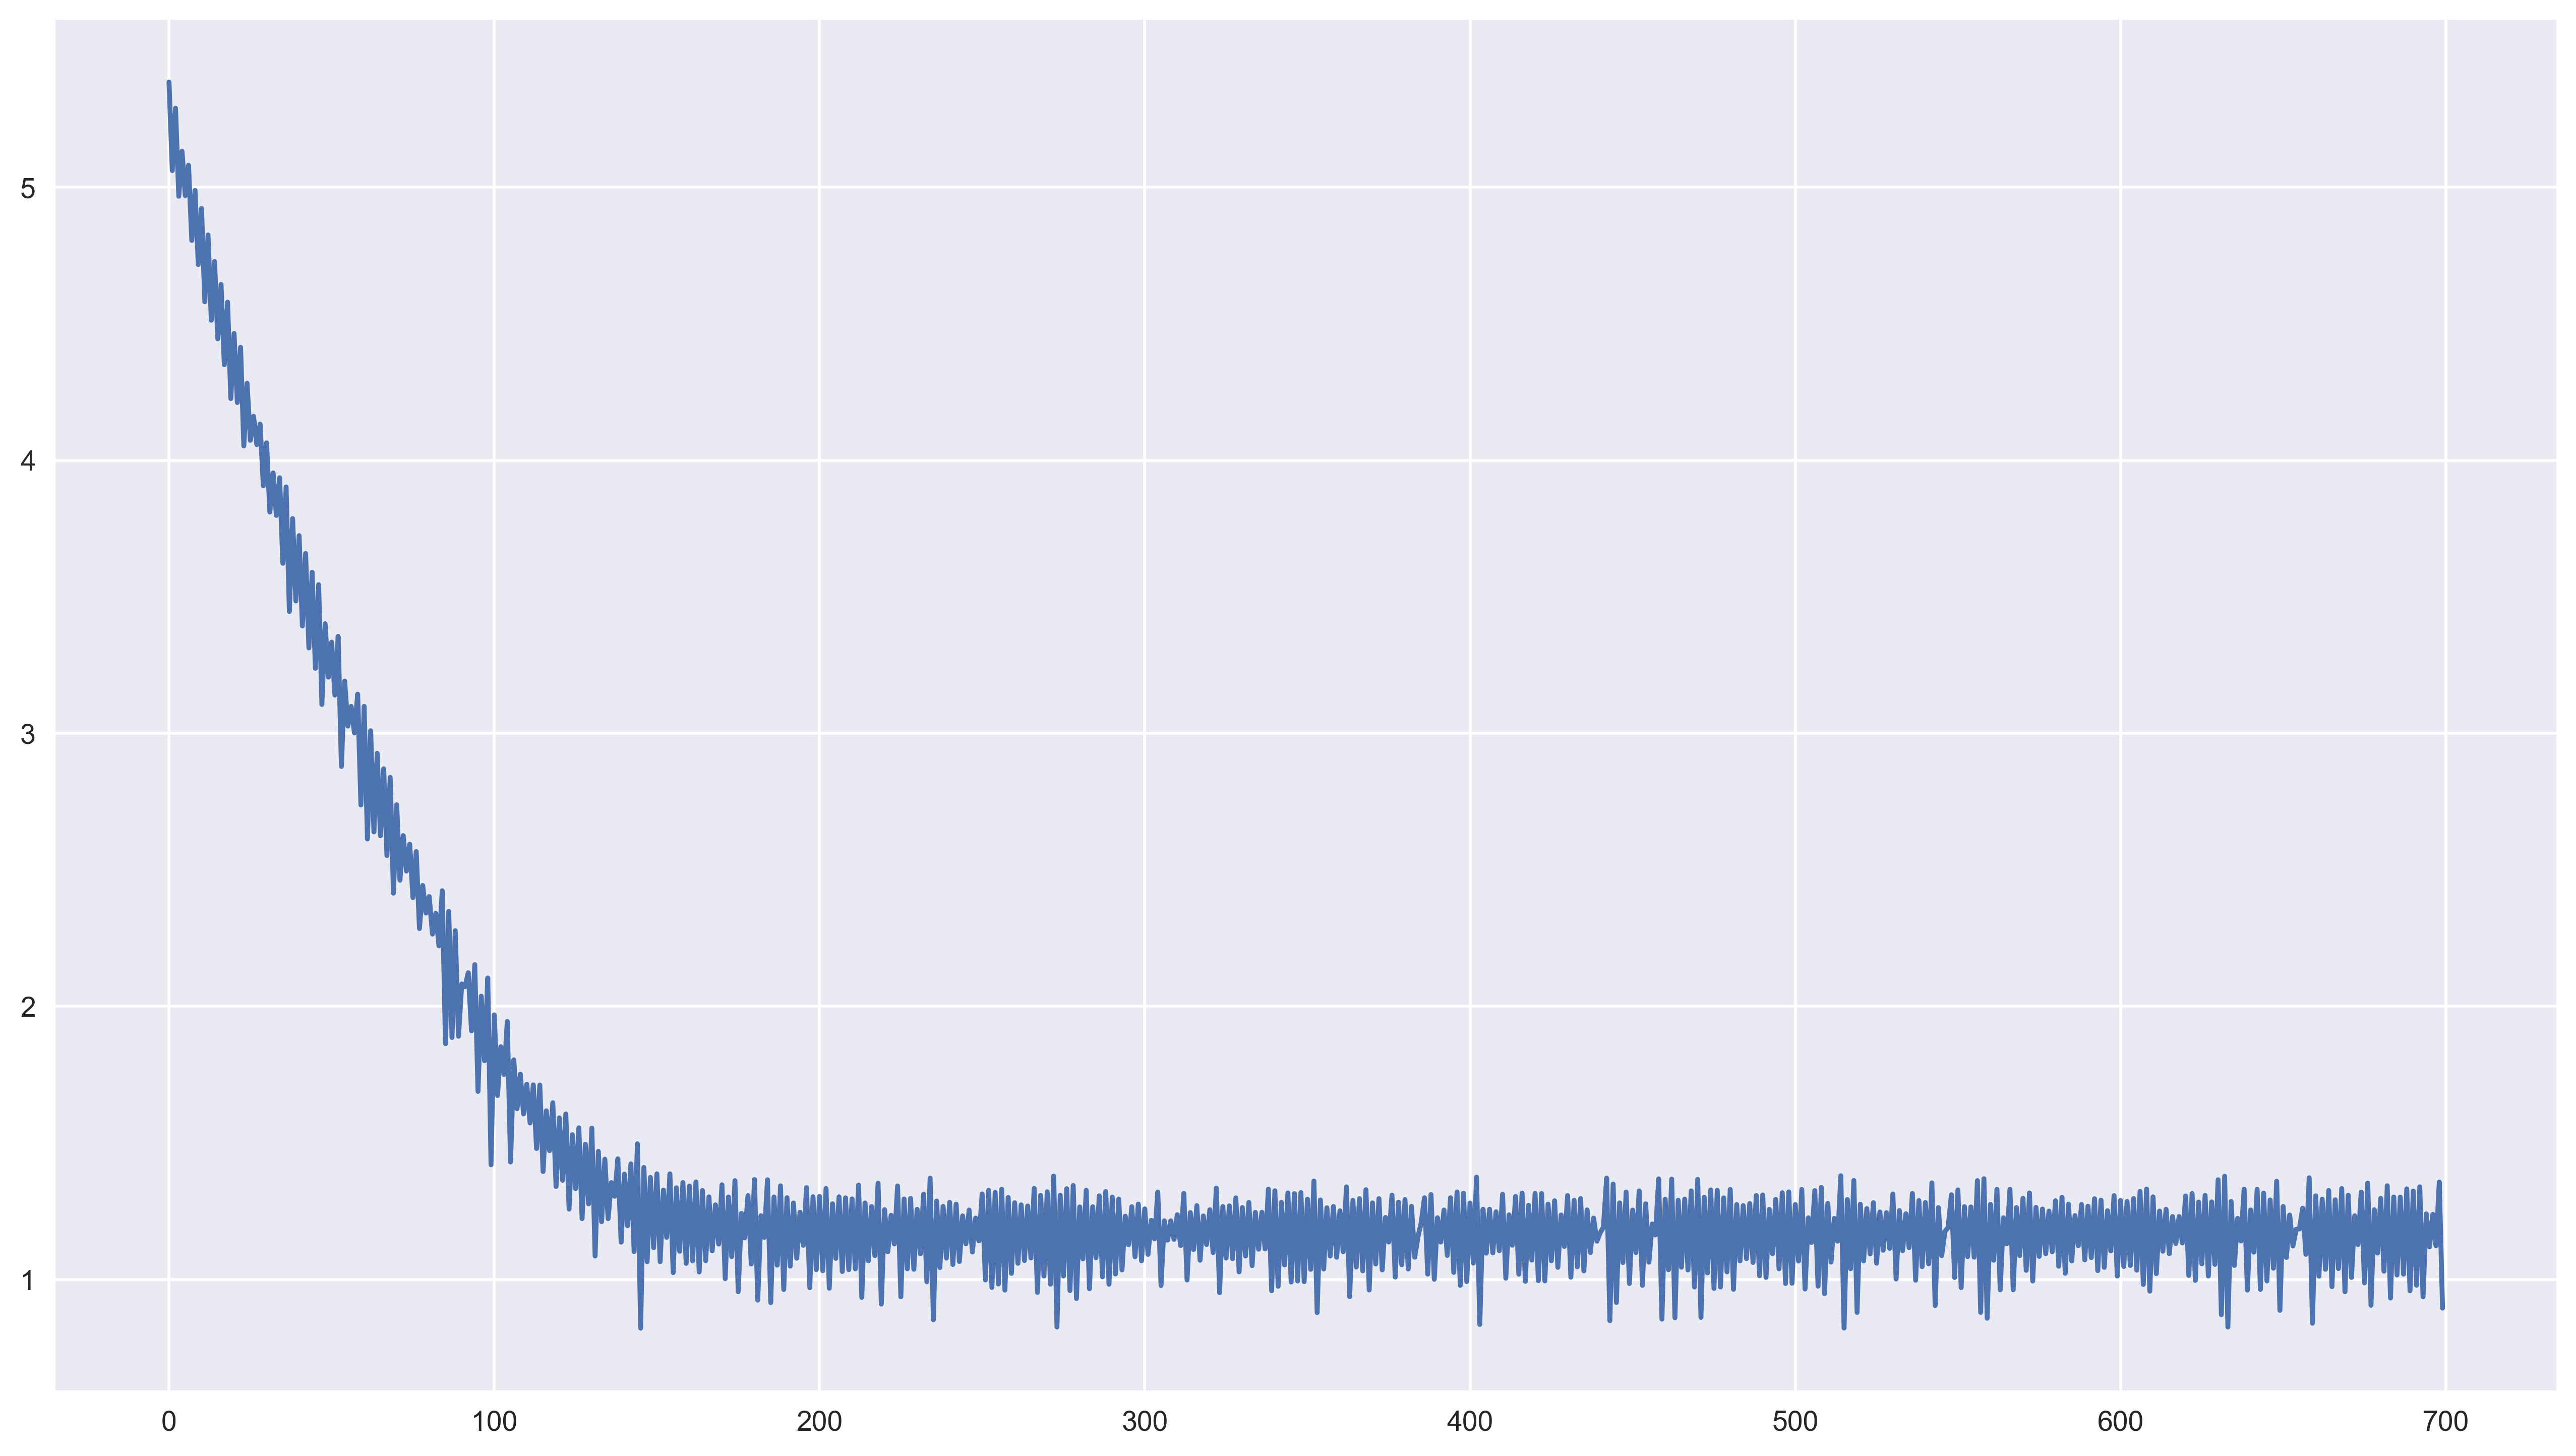

In [131]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(curves['gd-minibatch']['localerror']))
plt.show()

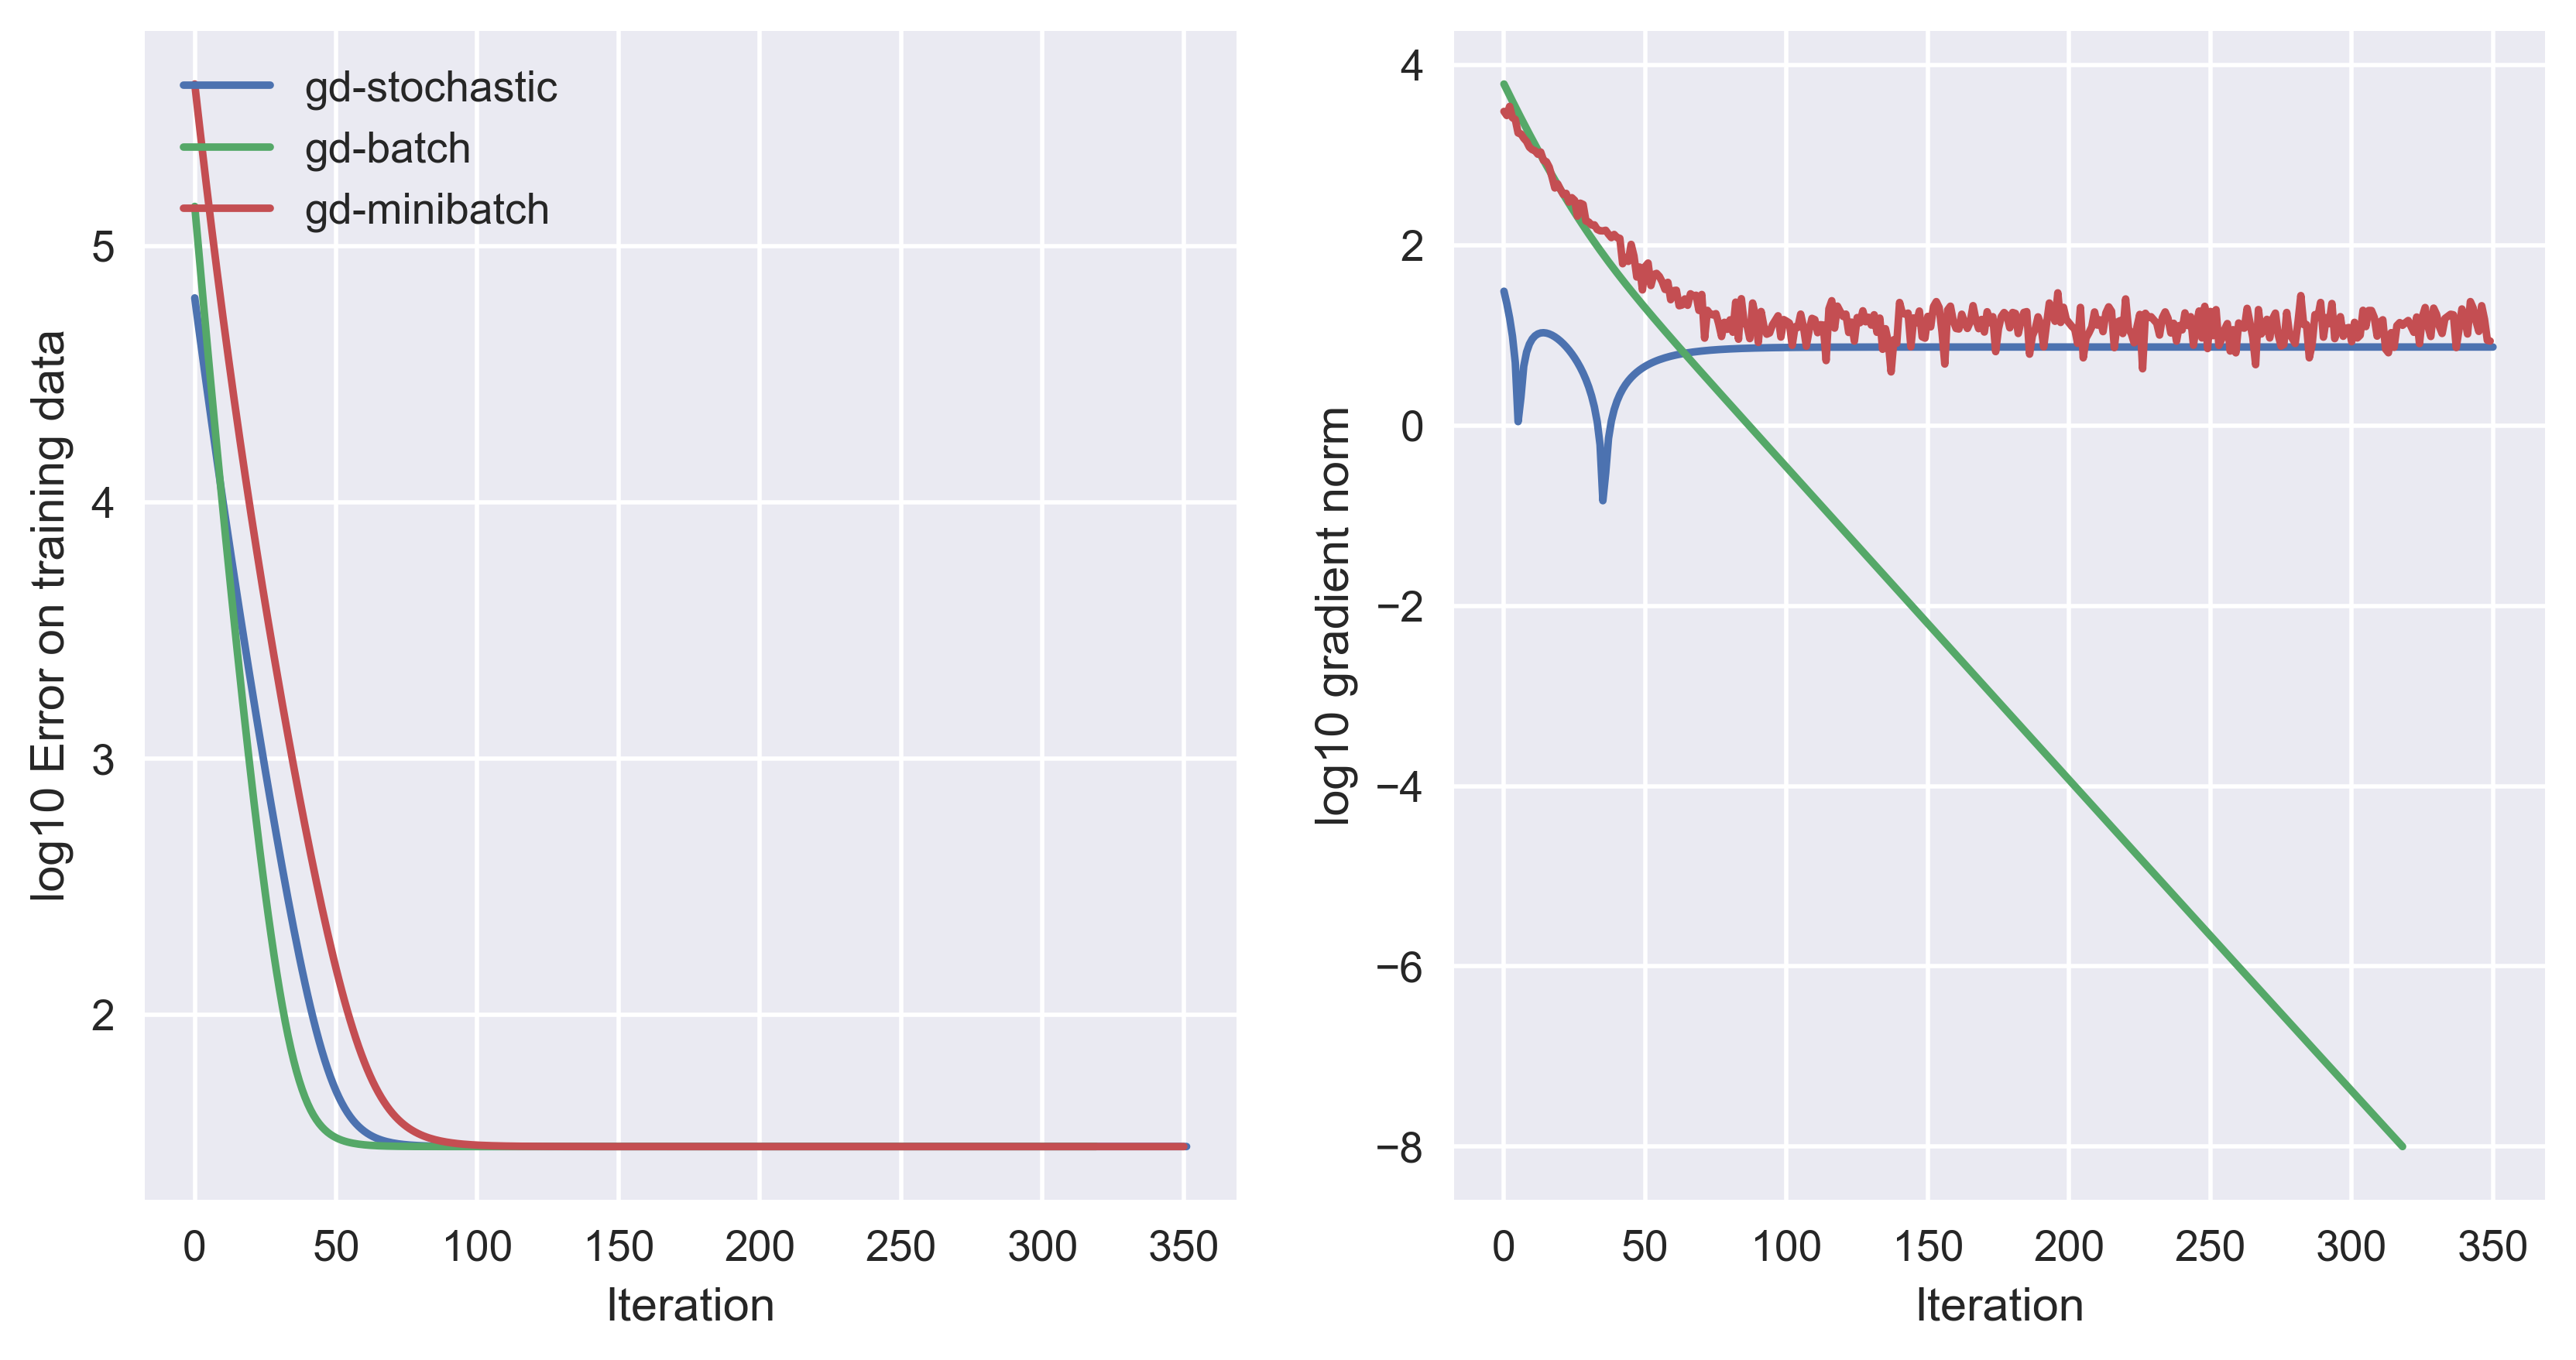

In [132]:
show_curves(curves)

# Advances in Gradient Descent

## Momentum update

In [133]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradientNorm = list()
gradient_fun = objective_function_gradient
learningRate = 0.01
gamma = 0.1
maxIter = 1000

t = time.time()
condition = True
niter = 0
gradupdate = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta, S)
    gradupdate = gradupdate*gamma + learningRate*gradient
    theta -= gradupdate#theta*gamma + learningRate*gradient
    niter += 1
    error.append(objective_function(theta, S))
    gradientNorm.append(np.linalg.norm(gradient))
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))
curves['momentum'] = {'error' : error, 'gradnorm': gradientNorm}

Computed 25 iterations in 0.15299987793 seconds.


In [134]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))

[-1.8330336   4.1830999   3.19576456  6.7639907   0.98641643]
[-2.  4.  3.  7.  1.]
Objective at theta 30.609389 and at orginal weights 36.399658
Gradient at theta: 0.0000000018242397


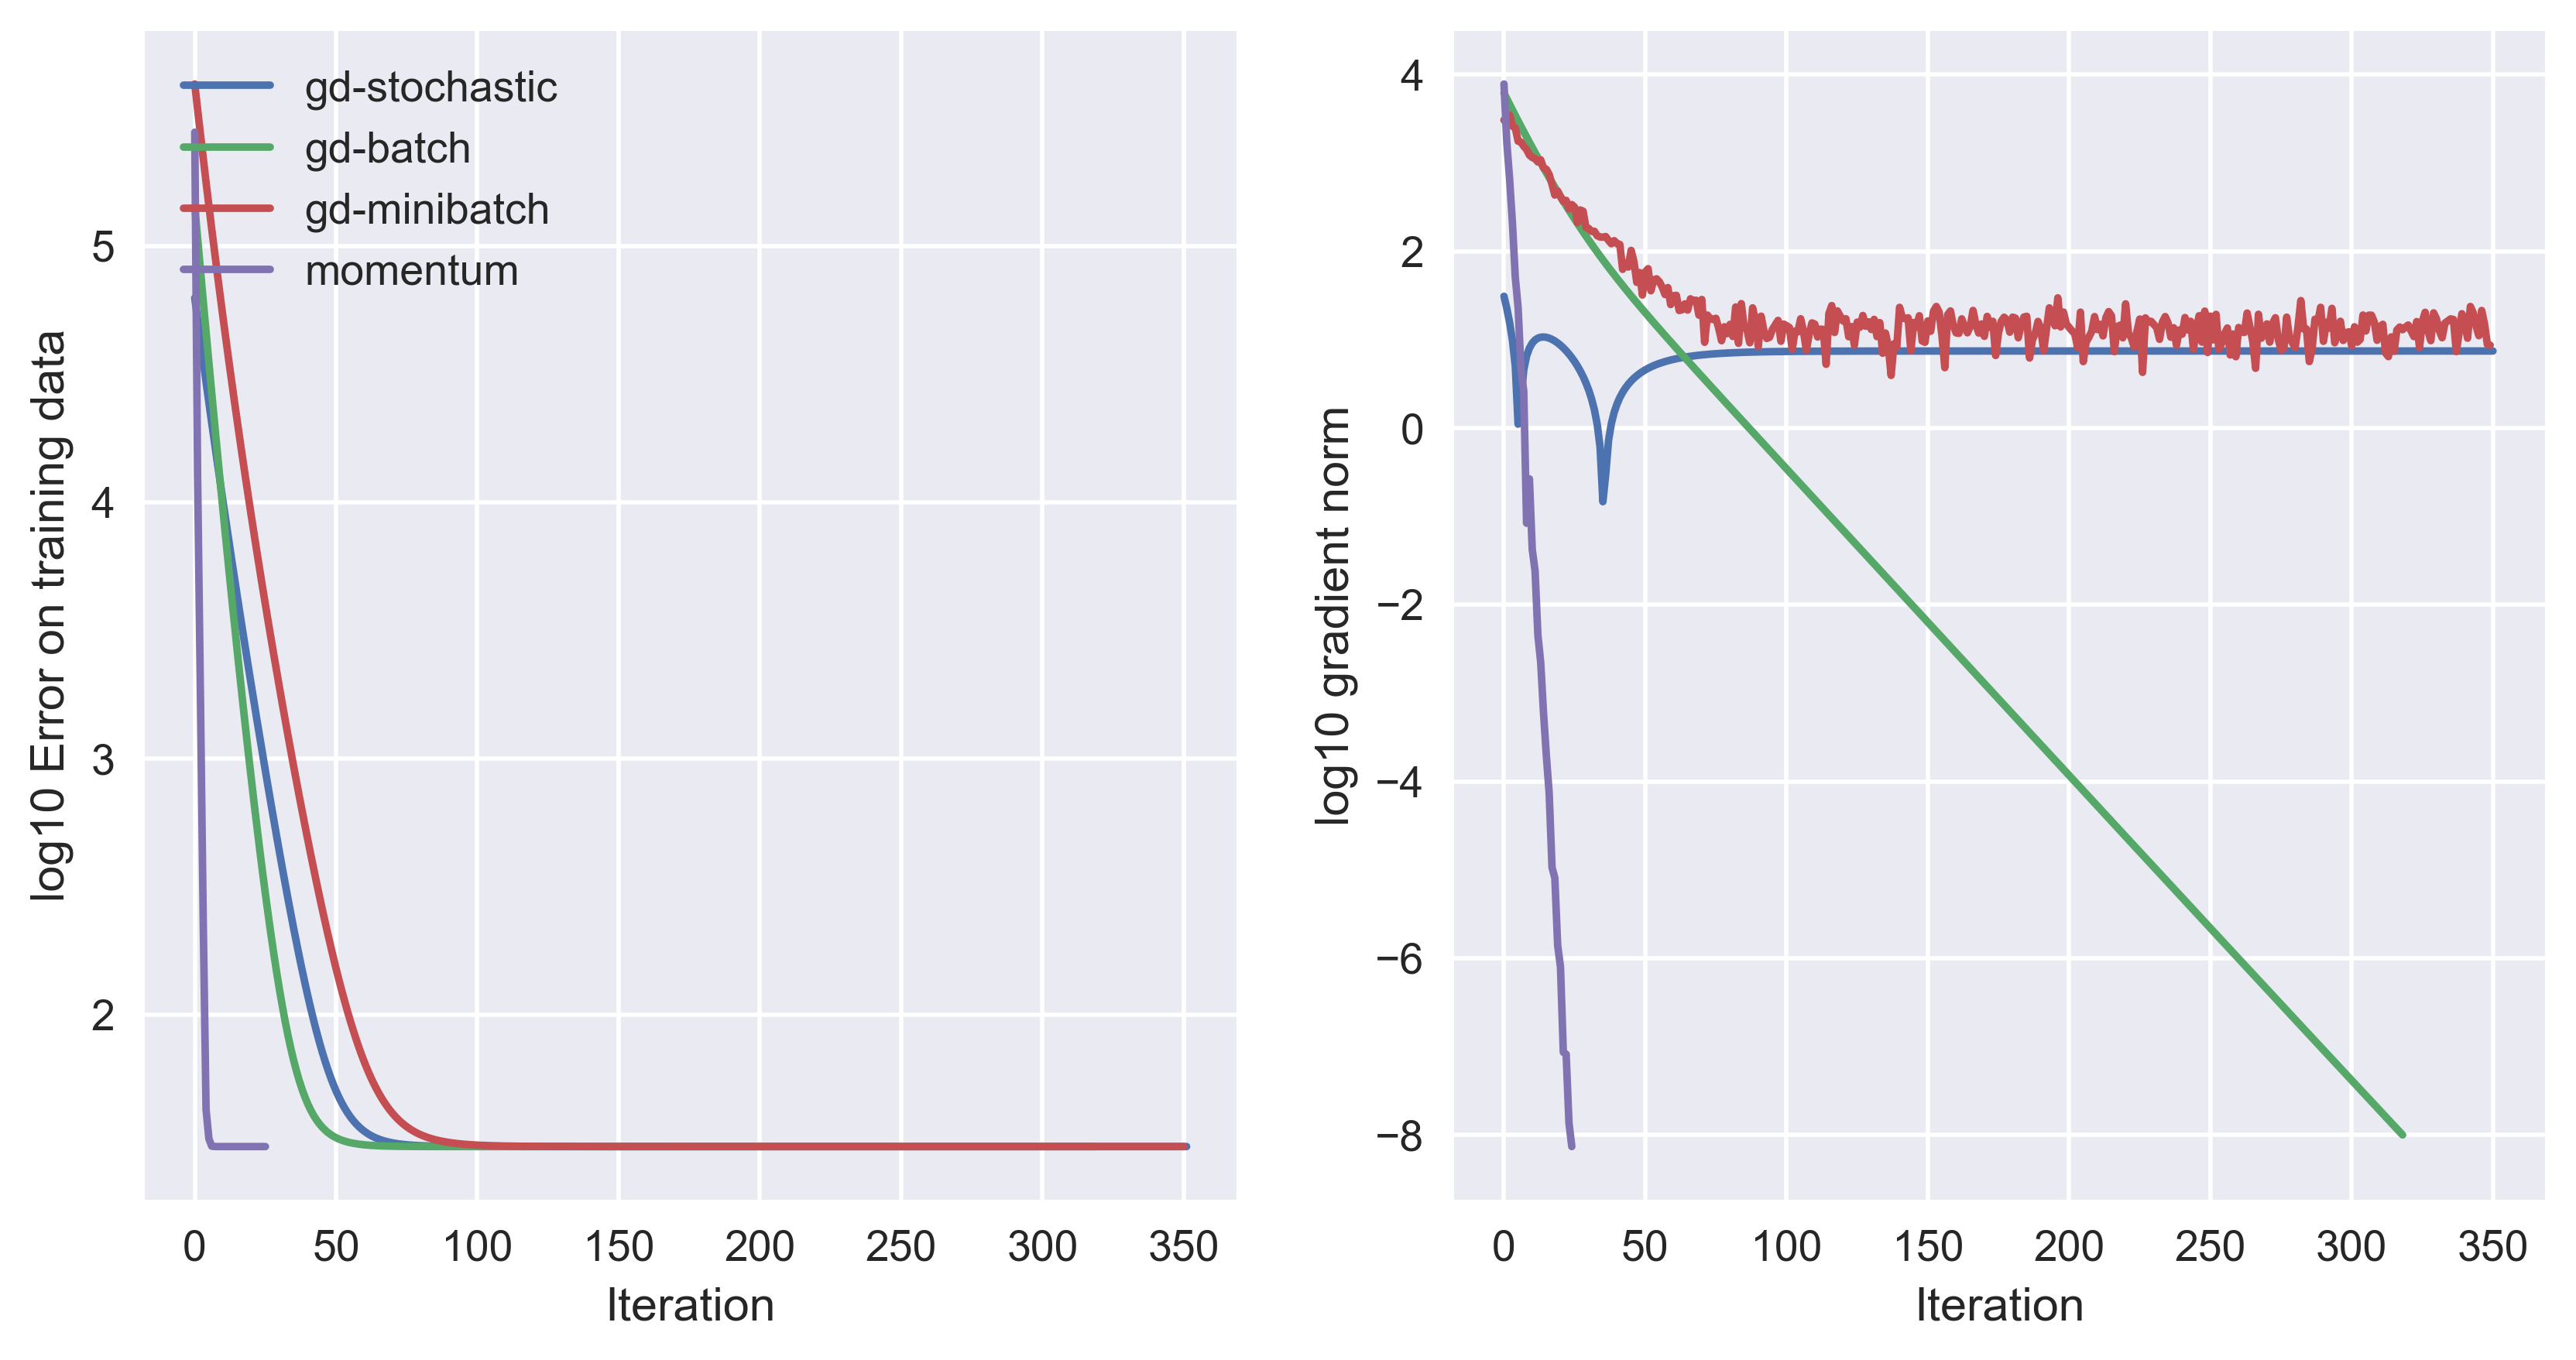

In [135]:
show_curves(curves)

### Mini Batch Variant

Computed in 2.60100007057 seconds
[-1.82903479  4.17318131  3.19986318  6.75500367  0.98434809]
[-2.  4.  3.  7.  1.]
Objective at theta 30.620879 and at orginal weights 36.399658
Gradient at theta: 1.6122557304441050


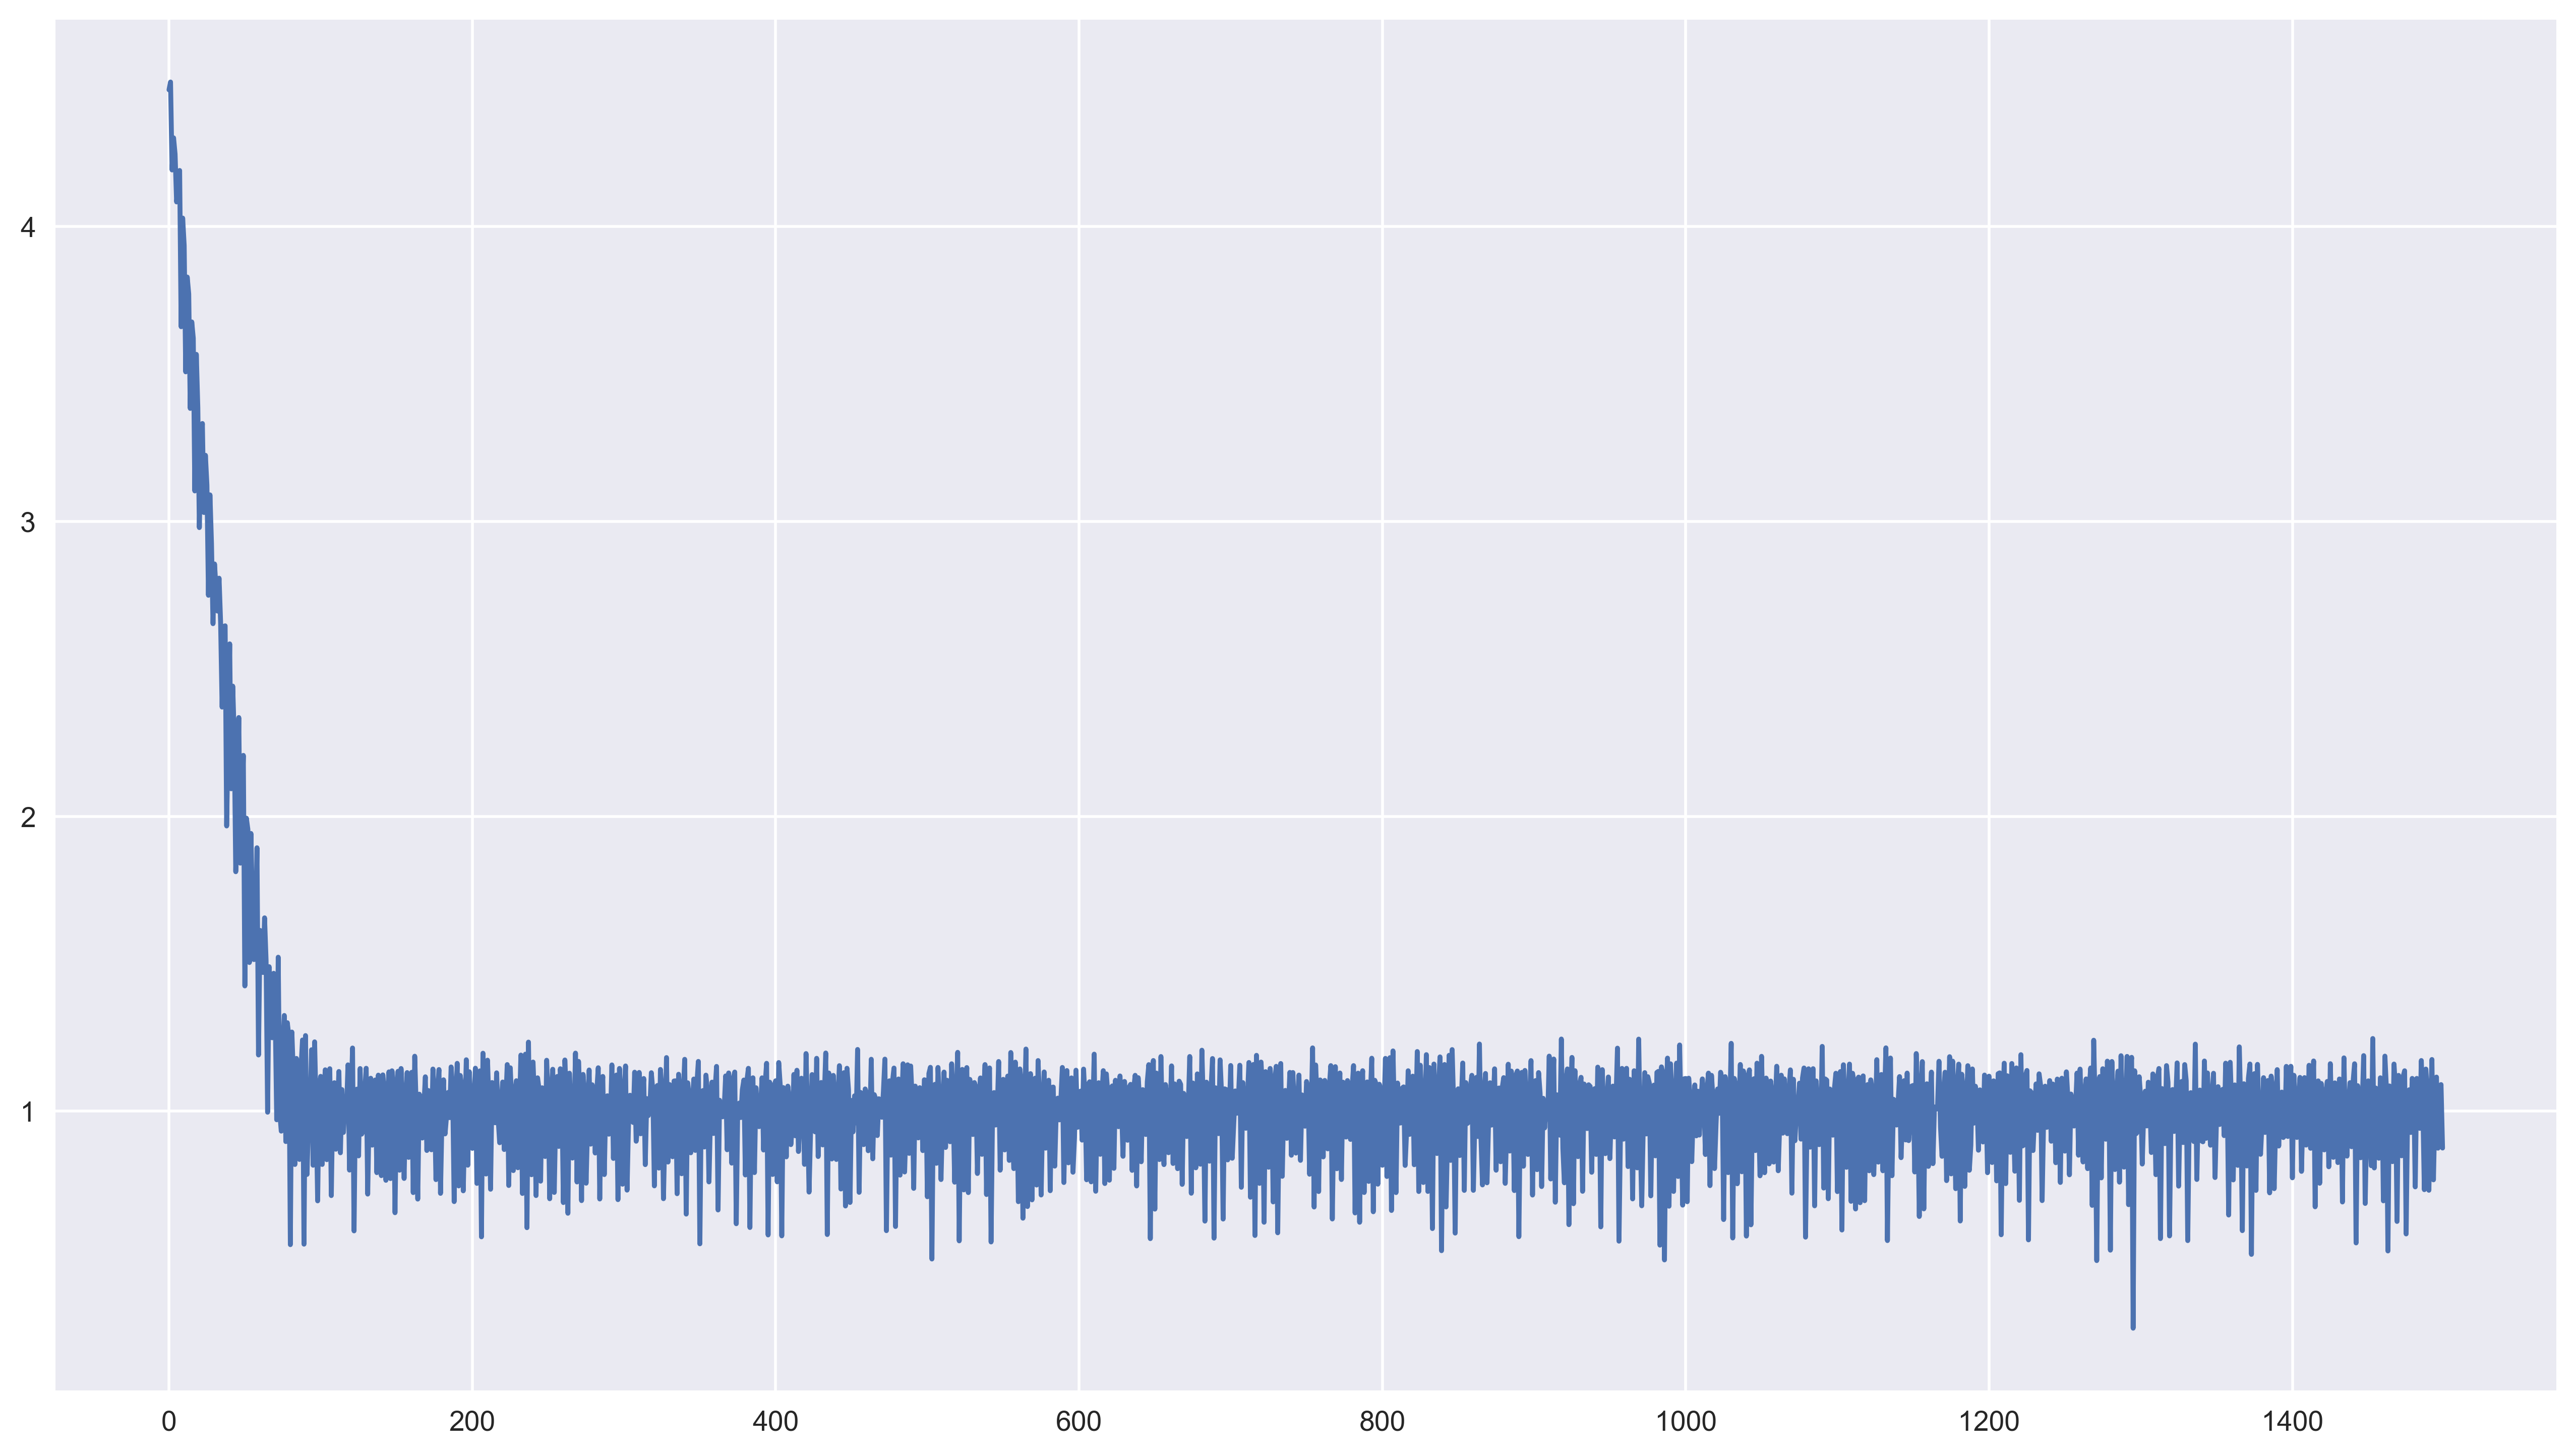

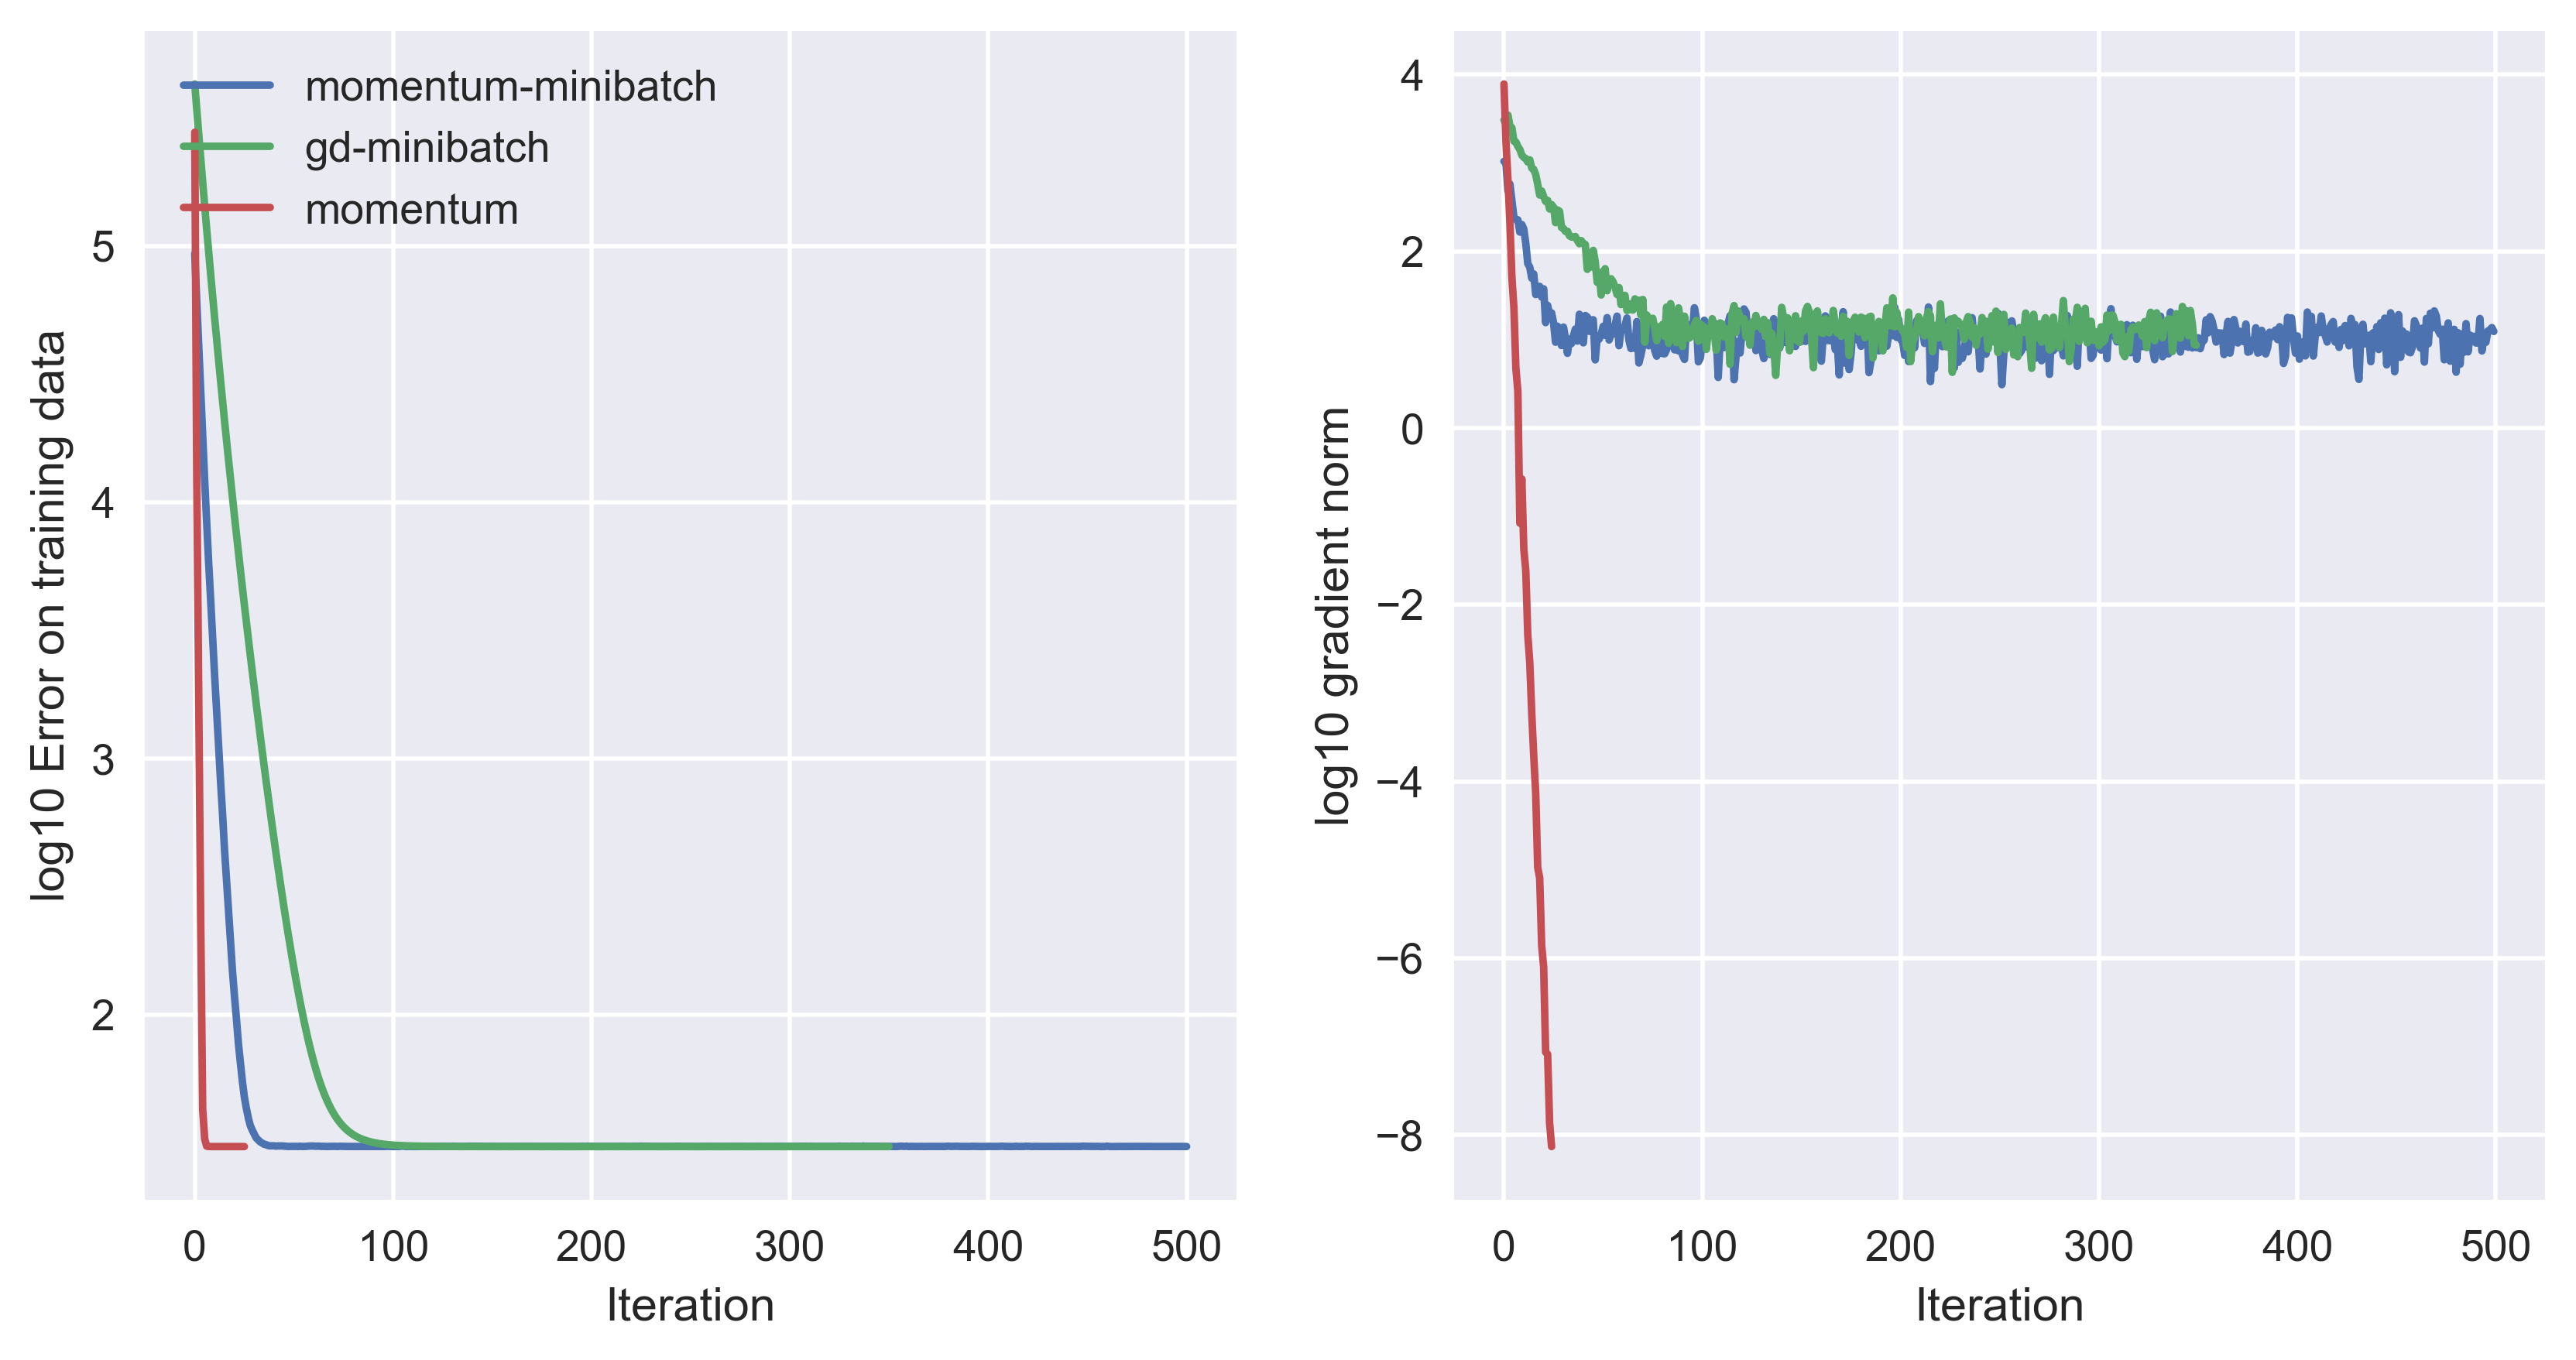

In [138]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
localError = []
gradientNorm = list()
error = [objective_function(theta, S)]
gradient_fun = objective_function_gradient
learningRate = 0.001
gamma = 0.9
batchSize = 20
maxIter = 100

t = time.time()
for epoch in xrange(500):
    rnd.shuffle(S)
    #learningRate = 0.01*np.exp(-0.01*epoch)
    batches = [S[i:i + batchSize] for i in xrange(0, len(S), batchSize)]
    gradupdate = 0
    for _S in batches:
        gradient = gradient_fun(theta, _S)
        gradupdate = gradupdate*gamma + learningRate*gradient
        theta -= gradupdate
        localError.append(objective_function(theta, _S))
    error.append(objective_function(theta, S))
    gradientNorm.append(np.linalg.norm(gradient))

curves['momentum-minibatch'] = {'error' : error, 'gradnorm': gradientNorm}
print 'Computed in %s seconds' % (time.time() - t)
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(localError))
plt.show()
show_curves(curves, exclude=['gd-stochastic', 'gd-batch', 'momentum-batch'])

## Nesterov Accelerated Momentum

In [139]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradientNorm = list()
gradient_fun = objective_function_gradient
learningRate = 0.001
gamma = 0.9
maxIter = 1000

t = time.time()
condition = True
niter = 0
previousGradient = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta - previousGradient*gamma, S)
    theta -= previousGradient*gamma + learningRate*gradient
    niter += 1
    error.append(objective_function(theta, S))
    gradientNorm.append(np.linalg.norm(gradient))
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
curves['momentum-nag'] = {'error' : error, 'gradnorm': gradientNorm}
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))

Computed 358 iterations in 1.72799992561 seconds.


[-1.8330336   4.1830999   3.19576456  6.7639907   0.98641643]
[-2.  4.  3.  7.  1.]
Objective at theta 30.609389 and at orginal weights 36.399658
Gradient at theta: 0.0000000087906034


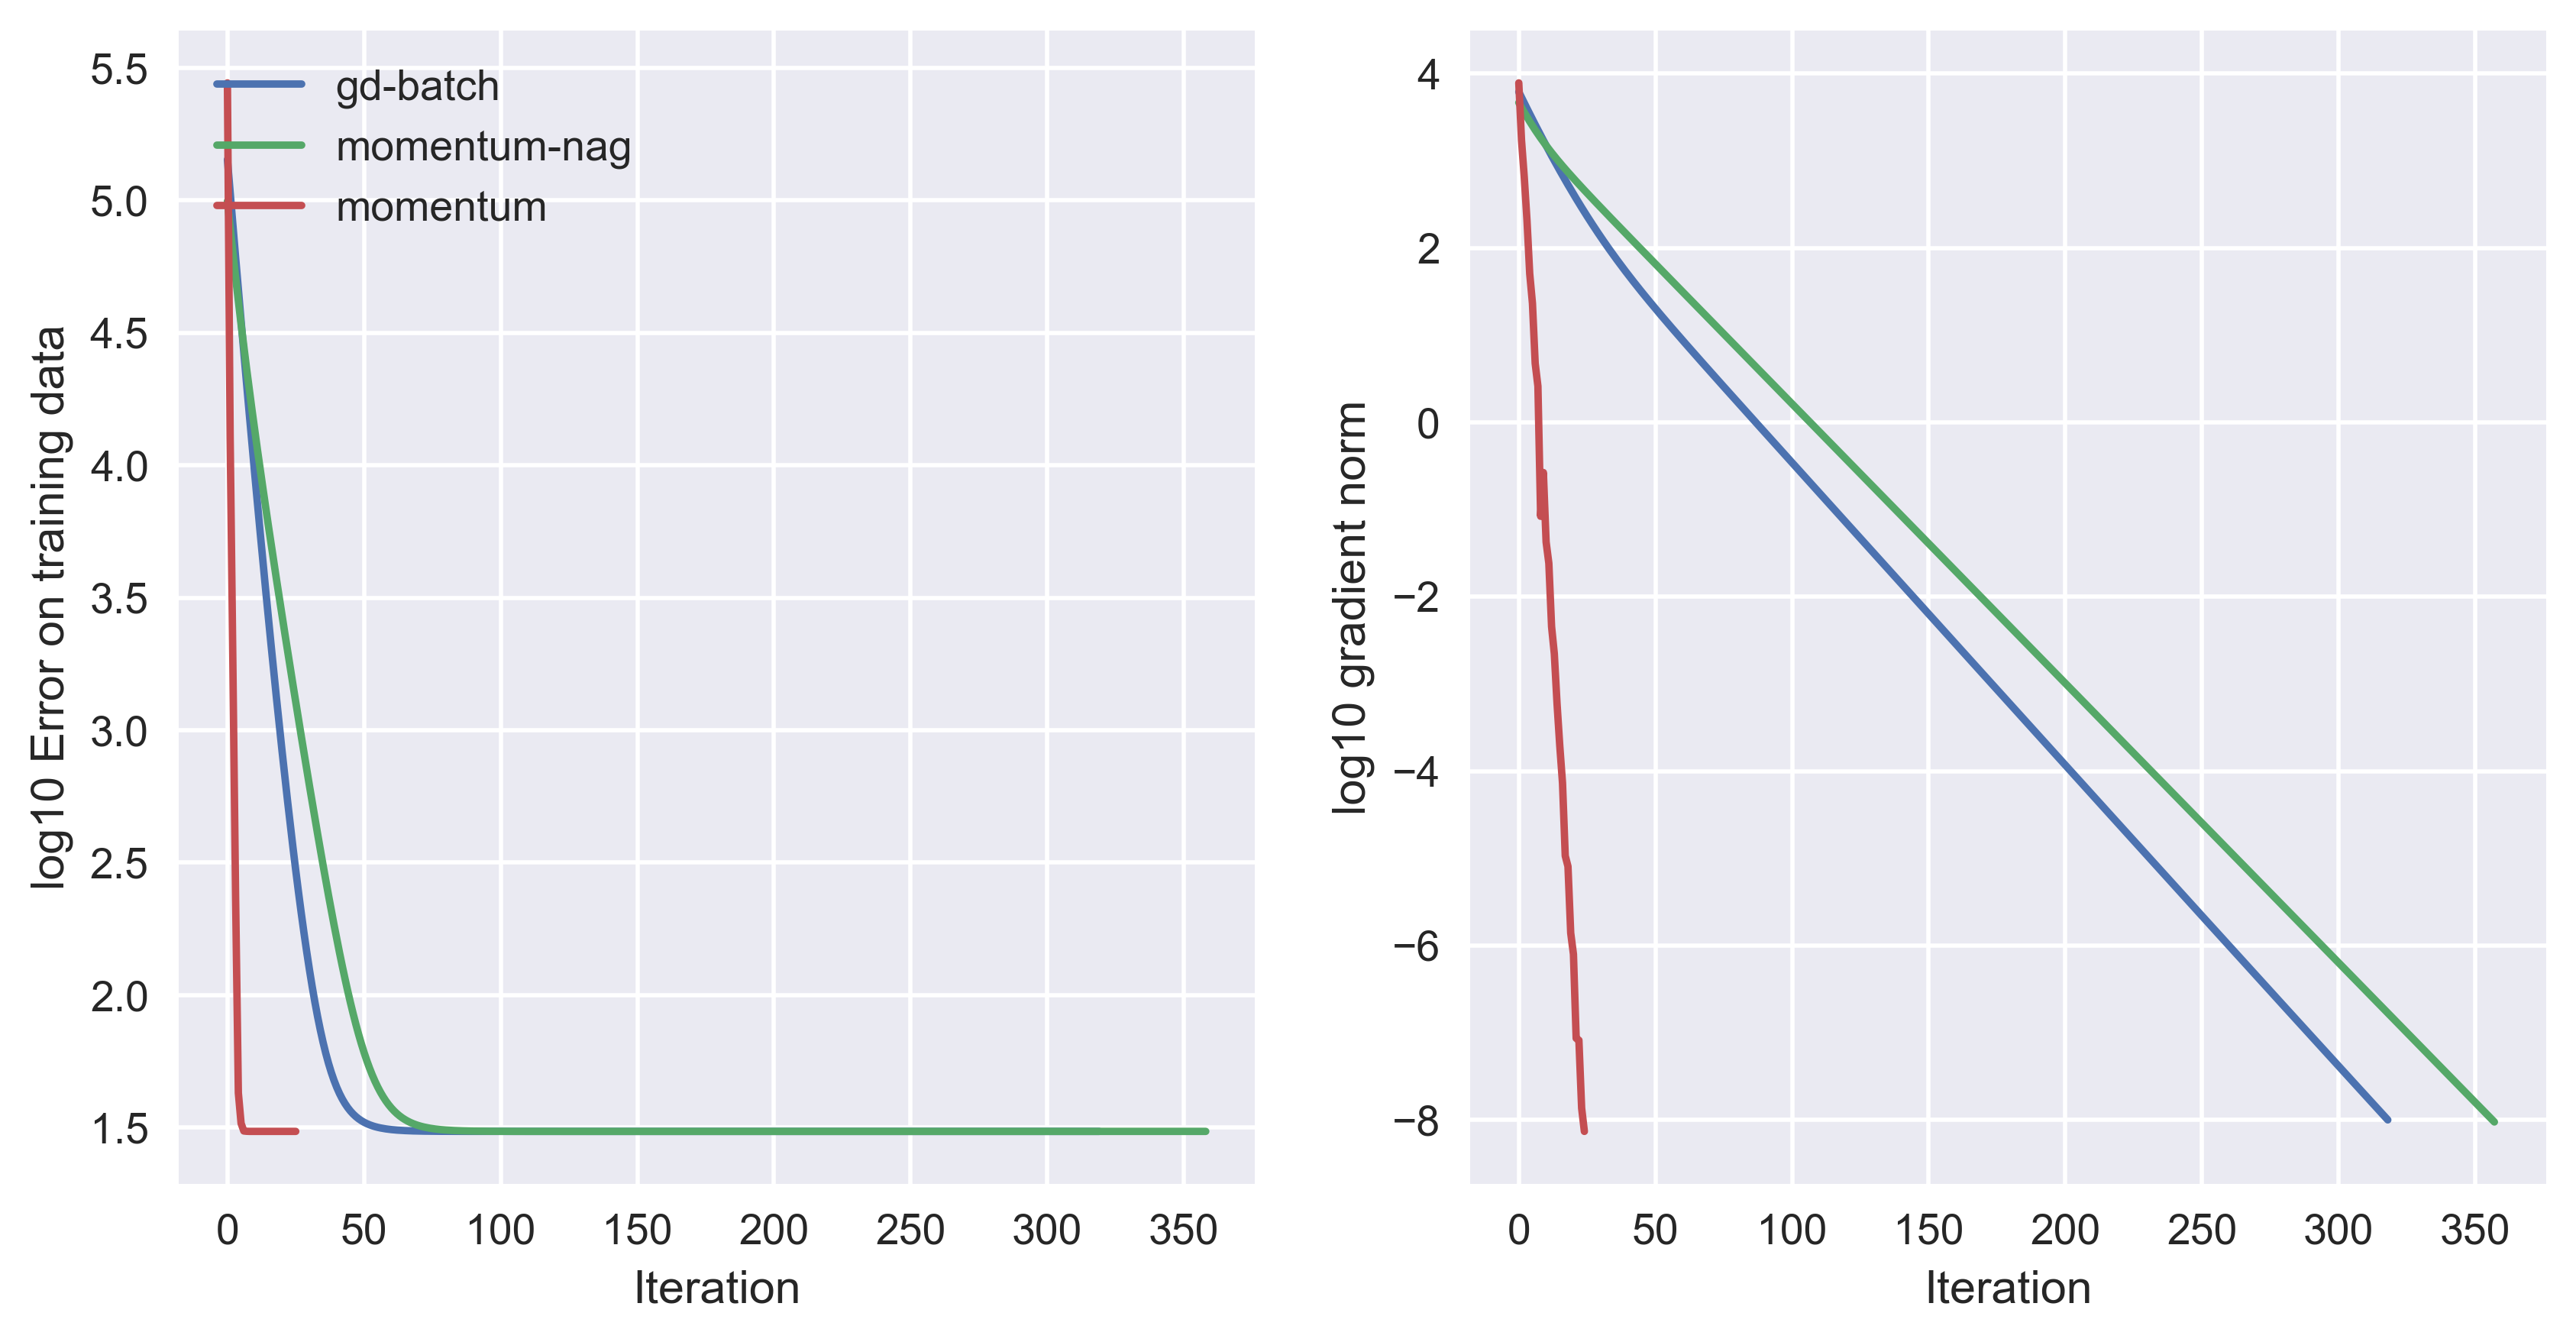

In [141]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
show_curves(curves, exclude=['gd-stochastic', 'gd-minibatch', 'momentum-batch', 'momentum-minibatch'])

## Adagrad

In [142]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradient_fun = objective_function_gradient
gradientNorm = list()
learningRate = 100
gradientHistory = np.zeros_like(theta)
epsilon = 1e-8
maxIter = 1000

t = time.time()
condition = True
niter = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta, S)
    gradientHistory += (gradient**2)
    theta -= (learningRate/np.sqrt(gradientHistory + epsilon))*gradient
    niter += 1
    error.append(objective_function(theta, S))
    gradientNorm.append(np.linalg.norm(gradient))
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
    
curves['adagrad'] = {'error' : error, 'gradnorm': gradientNorm}
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))


Computed 32 iterations in 0.1859998703 seconds.


[-1.8330336   4.1830999   3.19576456  6.7639907   0.98641643]
[-2.  4.  3.  7.  1.]
Objective at theta 30.609389 and at orginal weights 36.399658
Gradient at theta: 0.0000000018005824


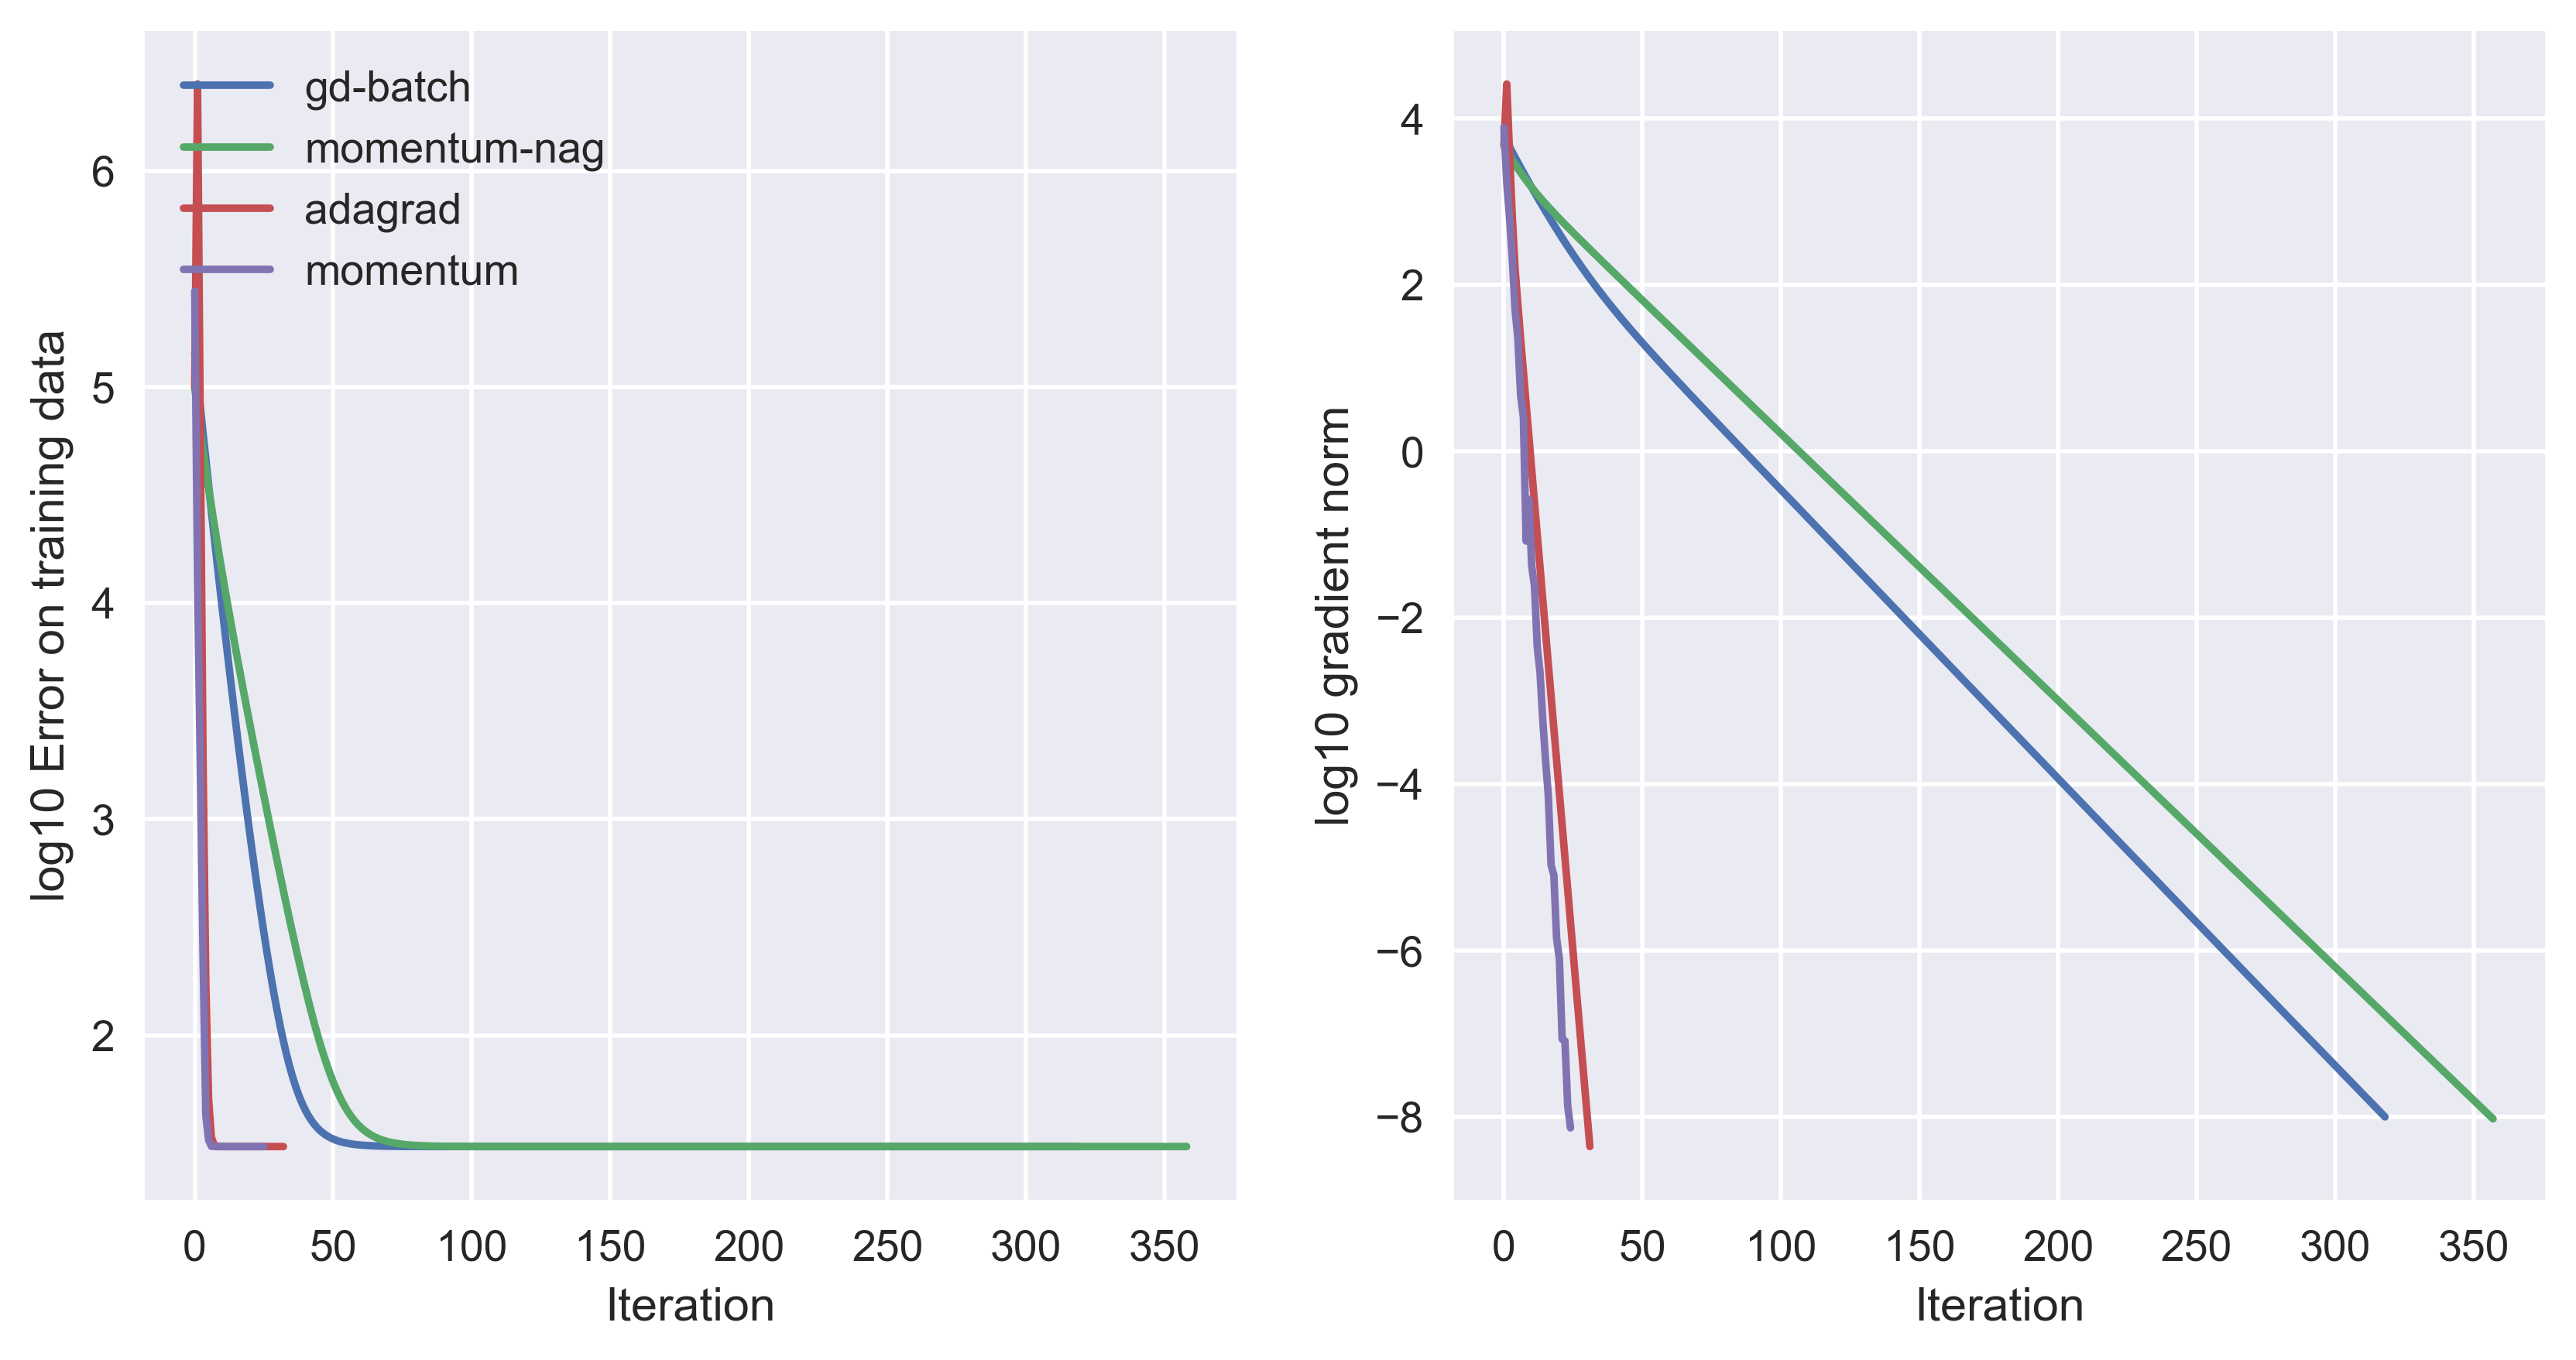

In [144]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
show_curves(curves, exclude=['gd-stochastic', 'gd-minibatch', 'momentum-batch', 'momentum-minibatch'])

## Adadelta

Naive computation using window size

In [179]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradientNorm = list()
gradient_fun = objective_function_gradient
learningRate = 1
windowSize = 100
gamma = 0.999
gradientHistory = np.zeros((len(theta), windowSize))
epsilon = 1e-8
maxIter = 1000

t = time.time()
condition = True
niter = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta, S)
    gradientHistory = np.roll(gradientHistory, 1)
    gradientHistory[:, 0] = gradient
    correctionTerm = (gradientHistory**2).mean(axis = 1)
    #print correctionTerm
    theta -= (learningRate/np.sqrt(correctionTerm + epsilon))*gradient
    niter += 1
    error.append(objective_function(theta, S))
    gradientNorm.append(np.linalg.norm(gradient))
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
    
curves['adadelta'] = {'error' : error, 'gradnorm': gradientNorm}
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))


Computed 354 iterations in 1.58100008965 seconds.


[-1.8330336   4.1830999   3.19576456  6.7639907   0.98641643]
[-2.  4.  3.  7.  1.]
Objective at theta 30.609389 and at orginal weights 36.399658
Gradient at theta: 0.0000000044111411


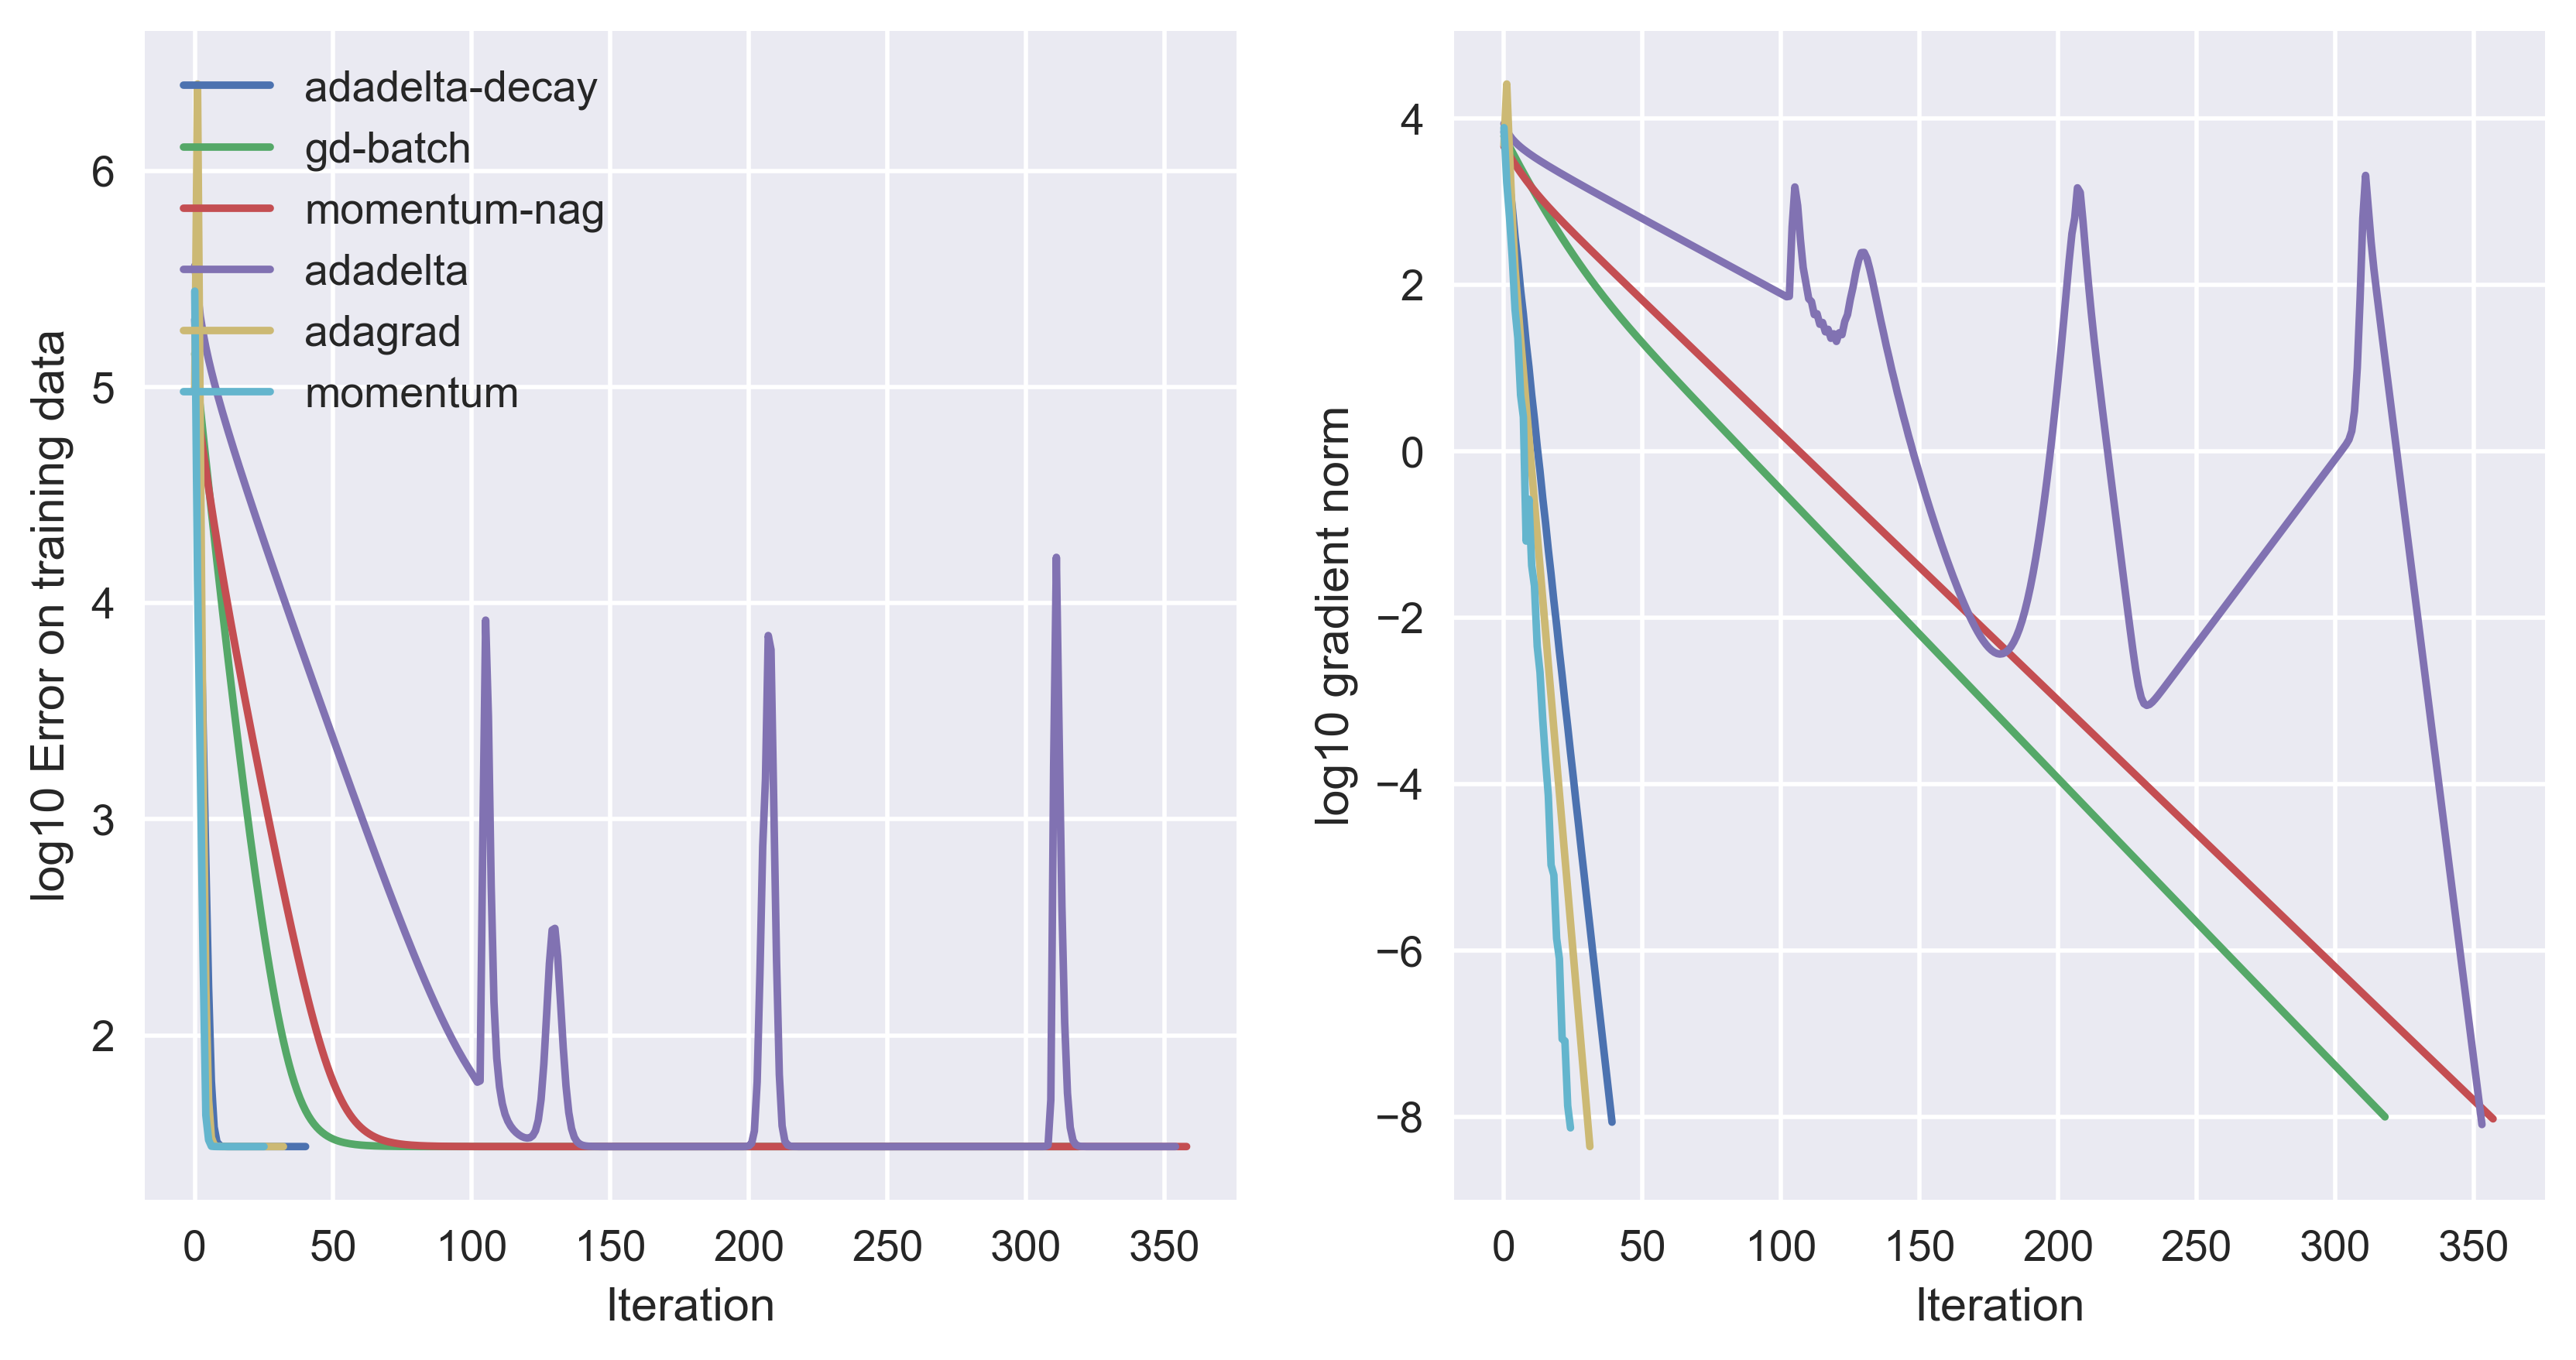

In [180]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
show_curves(curves, exclude=['gd-stochastic', 'gd-minibatch', 'momentum-batch', 'momentum-minibatch'])

Implementation using  decaying average

In [181]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradientNorm = list()
gradient_fun = objective_function_gradient
learningRate = 0.1#1#0.1
gamma = 0.999
previousGradient = np.zeros_like(theta)
epsilon = 1e-8
maxIter = 1000

t = time.time()
condition = True
niter = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta, S)
    previousGradient = gamma*previousGradient + (1 - gamma)*((learningRate*gradient)**2)
    #print correctionTerm
    theta -= (learningRate/np.sqrt(previousGradient + epsilon))*gradient
    niter += 1
    error.append(objective_function(theta, S))
    gradientNorm.append(np.linalg.norm(gradient))
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))
curves['adadelta-decay'] = {'error' : error, 'gradnorm': gradientNorm}

Computed 41 iterations in 0.258999824524 seconds.


[-1.8330336   4.1830999   3.19576456  6.7639907   0.98641643]
[-2.  4.  3.  7.  1.]
Objective at theta 30.609389 and at orginal weights 36.399658
Gradient at theta: 0.0000000047363484


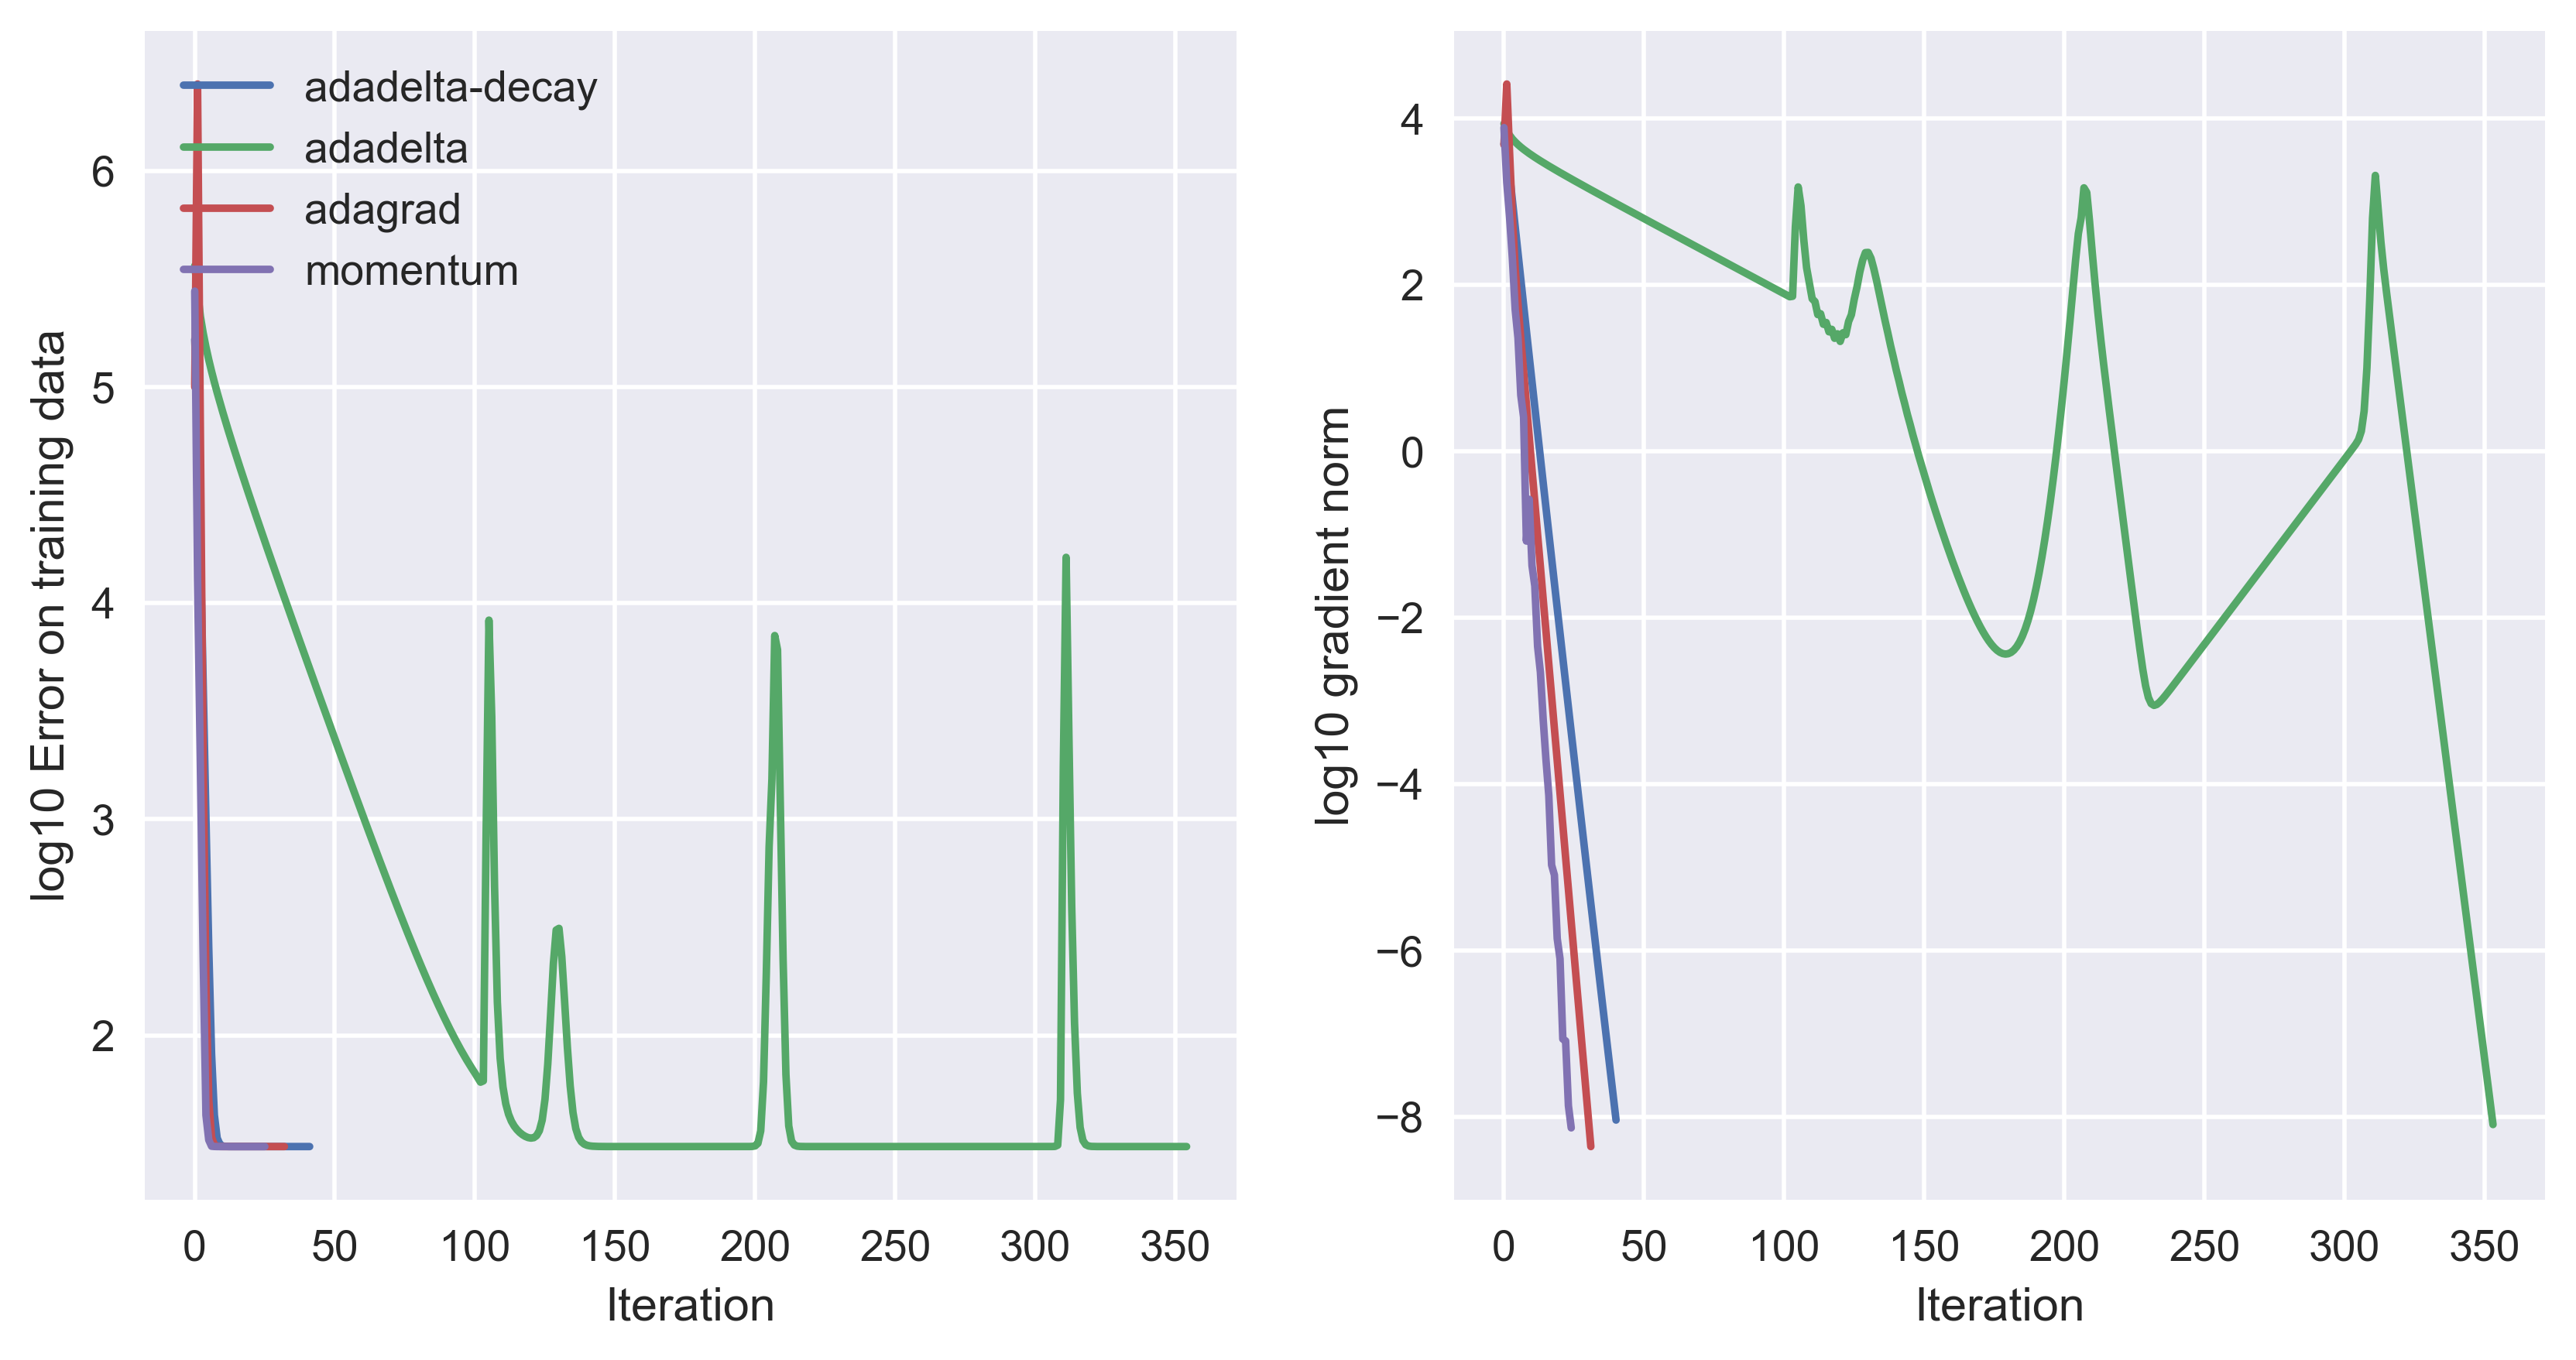

In [182]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
show_curves(curves, exclude=['gd-stochastic', 'gd-minibatch', 'momentum-batch', 'momentum-minibatch', 'gd-batch', 'momentum-nag'])

## Adam

Additionally adaps momentum for each parameter.

In [214]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradientNorm = list()
gradient_fun = objective_function_gradient
learningRate = 1#0.1
beta1 = 0.8
beta2 = 0.9999
m = np.zeros_like(theta)
v = np.zeros_like(theta)
epsilon = 1e-8
maxIter = 1000

t = time.time()
condition = True
niter = 0
while condition:
    niter += 1
    gradient = gradient_fun(theta, S)
    m = beta1*m + (1 - beta1)*gradient
    v = beta2*v + (1 - beta2)*(gradient**2)
    mt = m/(1. - beta1**niter)
    vt = v/(1. - beta2**niter)
    theta -= ((learningRate*mt)/(np.sqrt(vt) + epsilon)) # <- no gradient term
    error.append(objective_function(theta, S))
    gradientNorm.append(np.linalg.norm(gradient))
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))
curves['adam'] = {'error' : error, 'gradnorm': gradientNorm}

Computed 262 iterations in 1.20599985123 seconds.


[-1.8330336   4.1830999   3.19576456  6.7639907   0.98641643]
[-2.  4.  3.  7.  1.]
Objective at theta 30.609389 and at orginal weights 36.399658
Gradient at theta: 0.0000000066850864


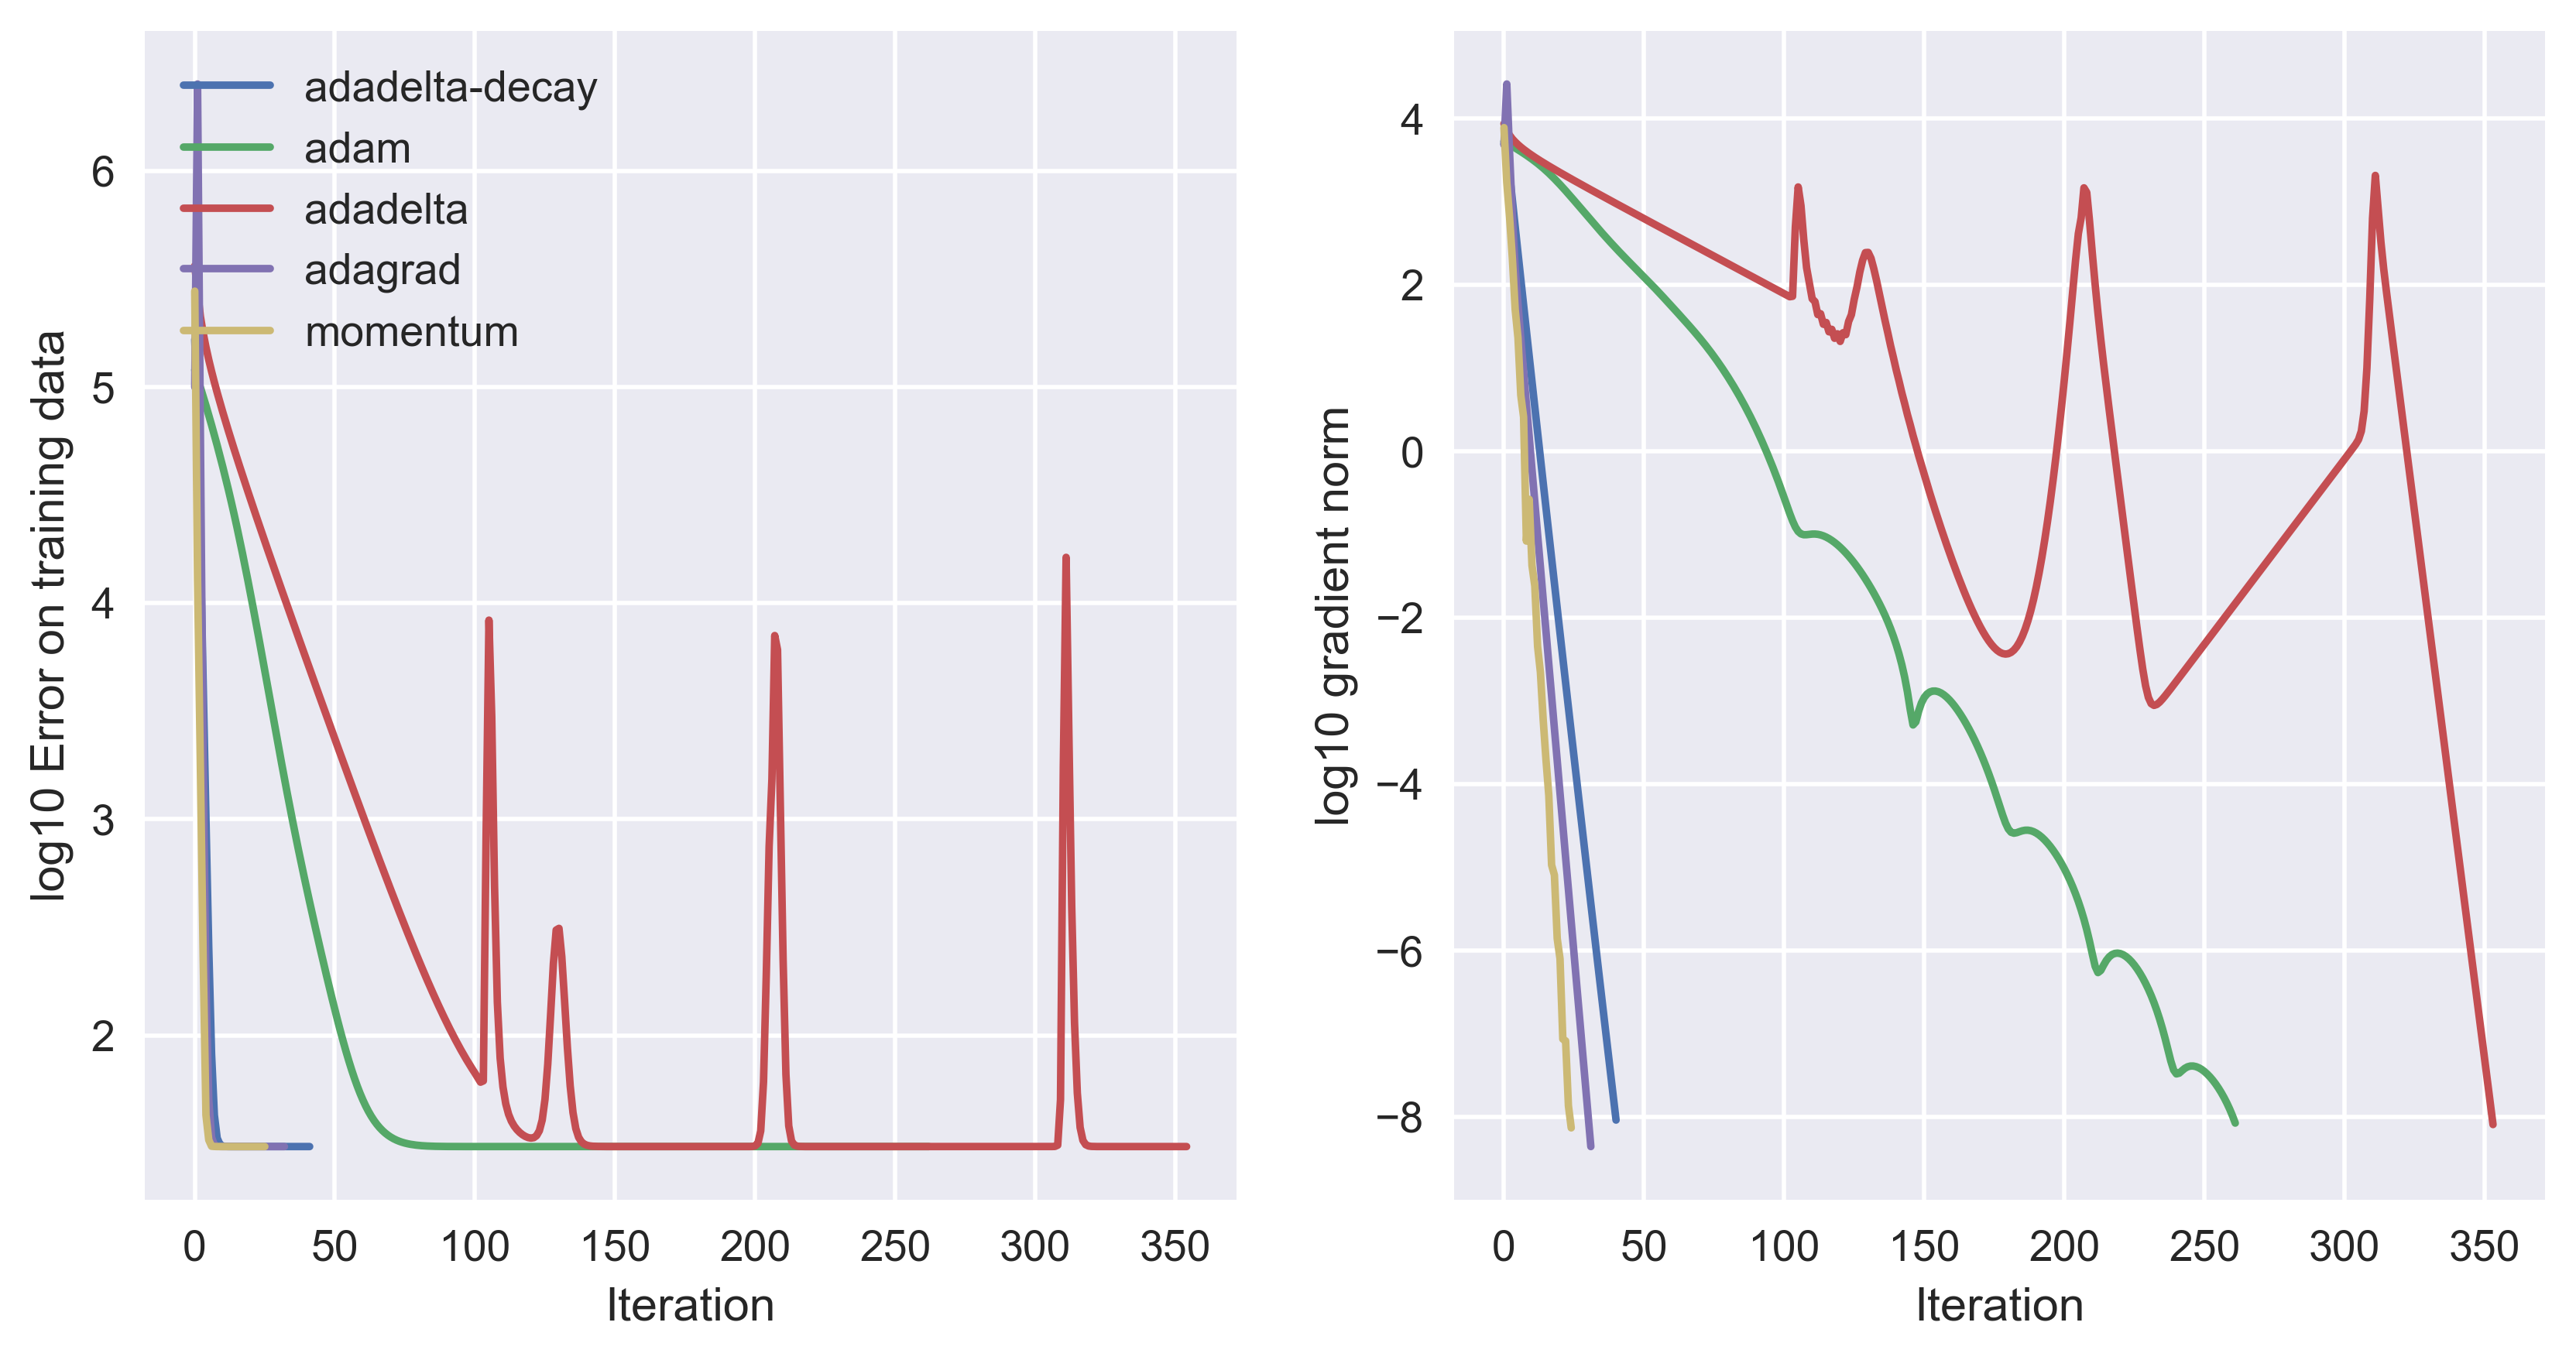

In [216]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
show_curves(curves, exclude=['gd-stochastic', 'gd-minibatch', 'momentum-batch', 'momentum-minibatch', 'gd-batch', 'momentum-nag'])

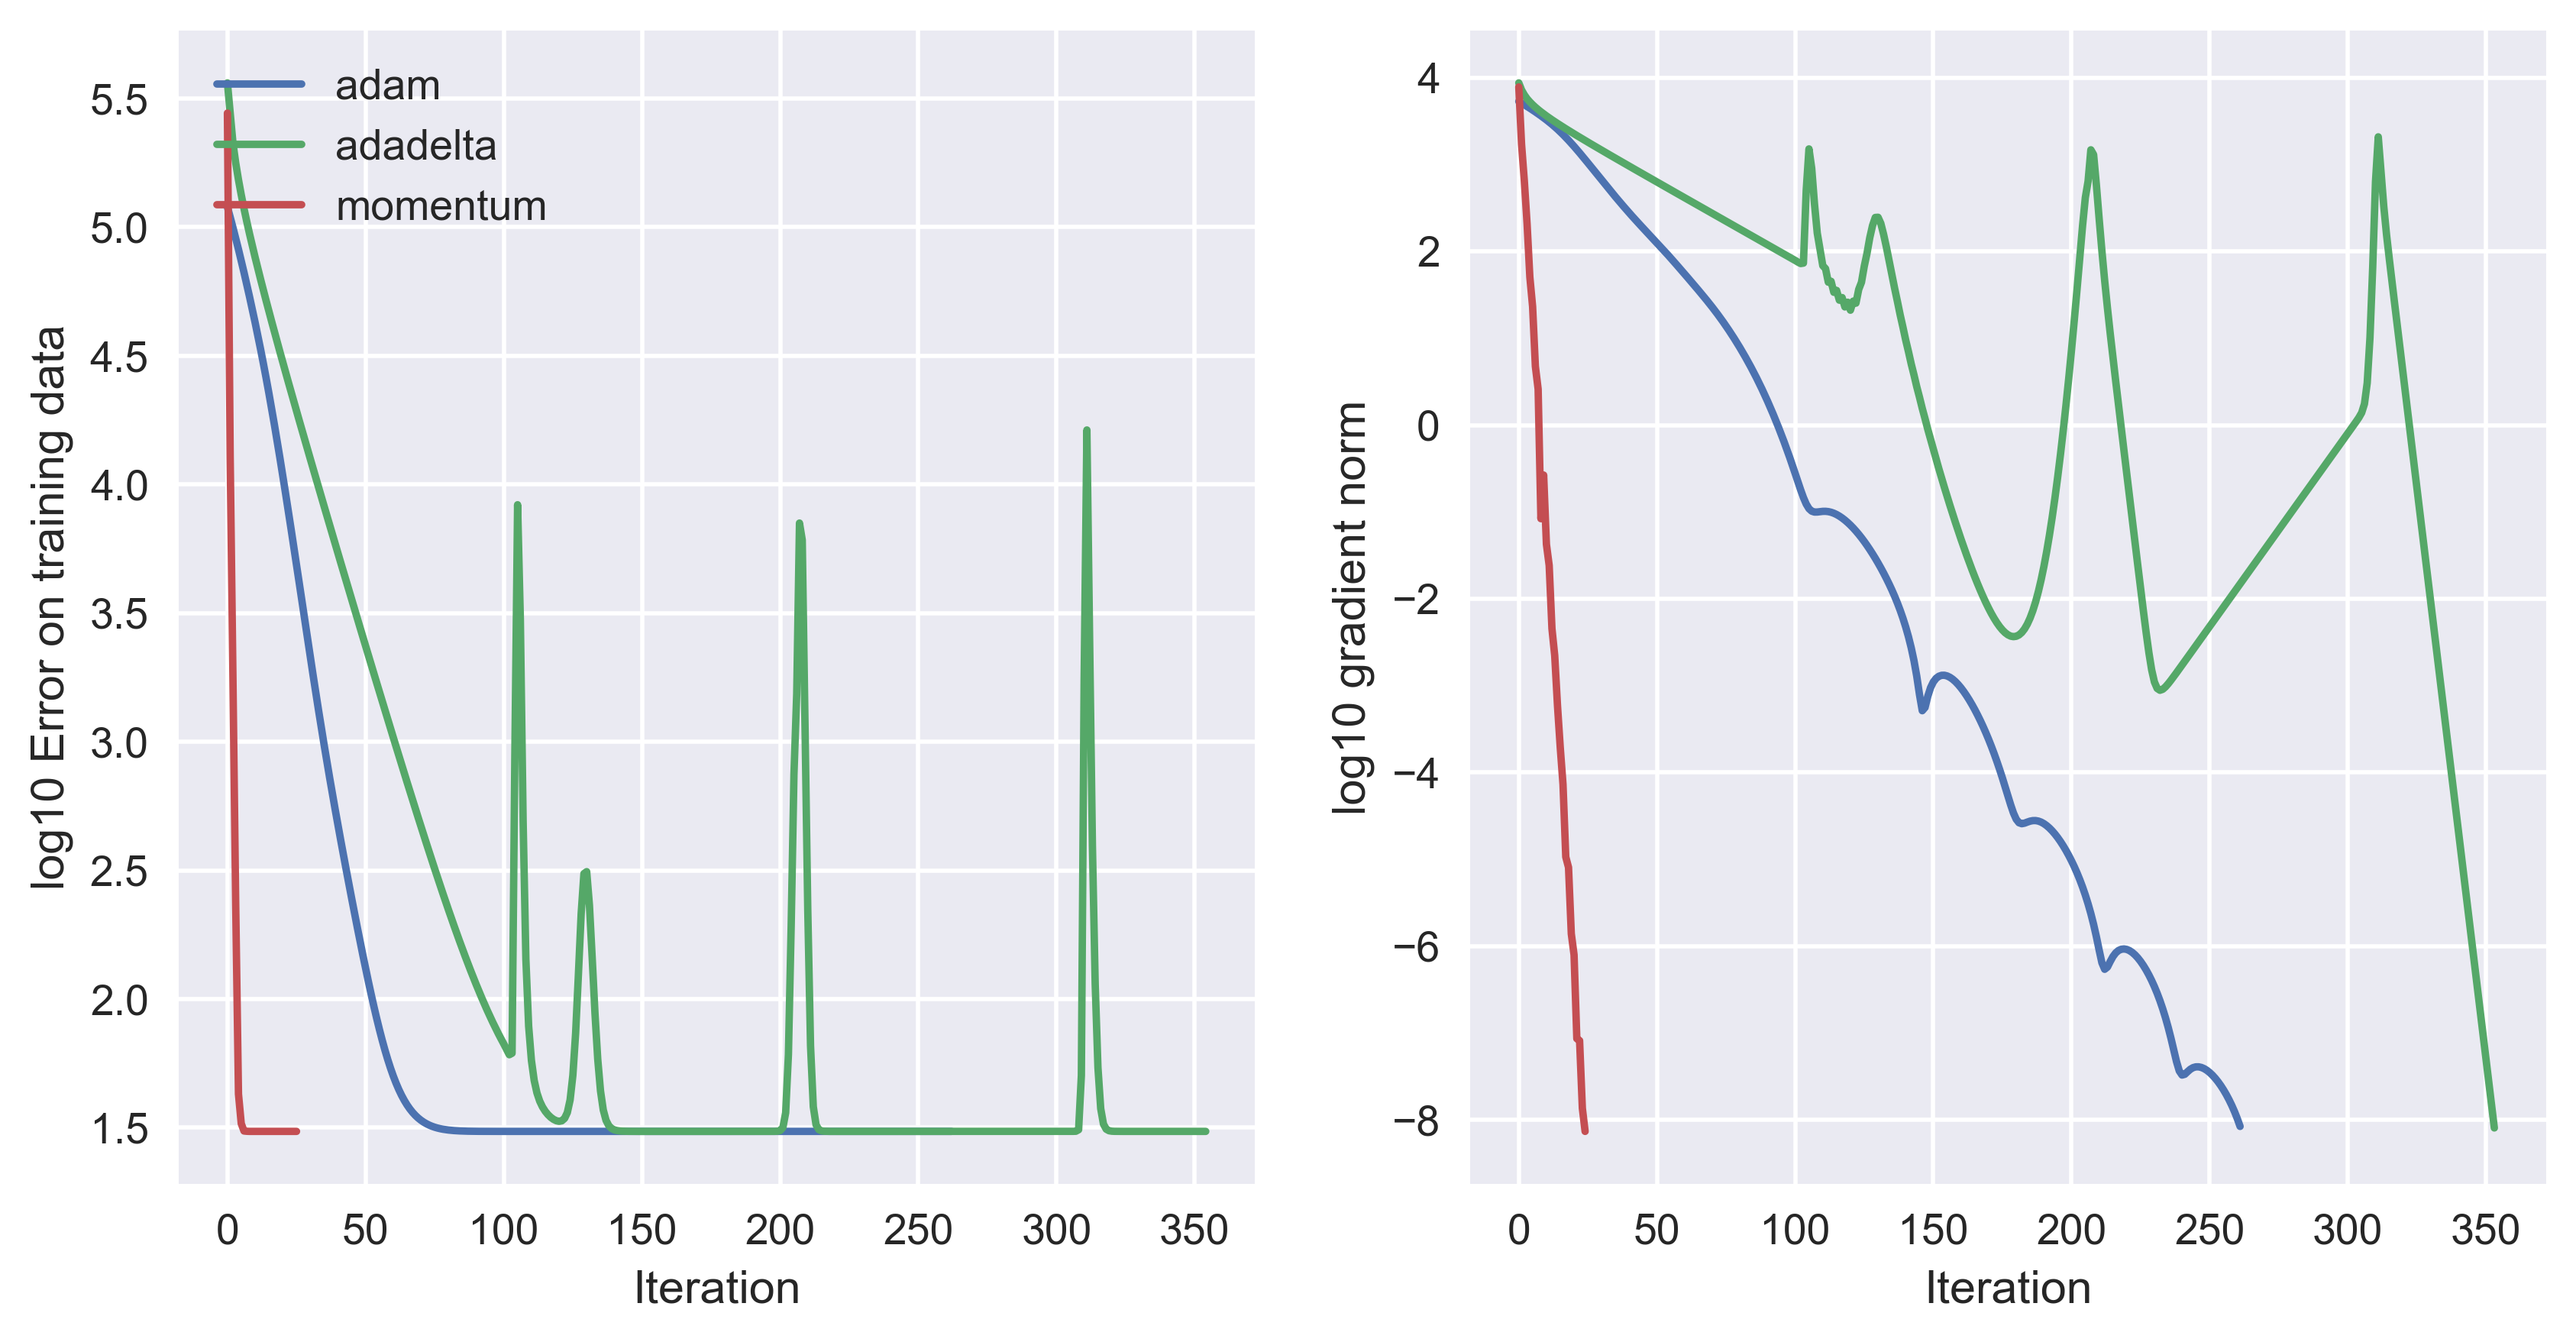

In [220]:
show_curves(curves, exclude=['gd-stochastic', 
                             'gd-minibatch', 
                             'momentum-batch', 
                             'momentum-minibatch', 
                             'gd-batch', 
                             'momentum-nag', 'adagrad', 'adadelta-decay'])

# Code optimization

## Differentiation

In [ ]:
# Maybe it can be imporoved by moving away the data
class SimpleModel(object):
    
    def __init__(self, S):
        self.x, self.y = zip(*S)
        self.objective_gradient = grad(self.objective)
        
    def model(self, weights):
        return np.array([weights[0] + np.sum(x*weights[1:]) for x in self.x])
        
    def objective(self, theta):
        return np.sum((self.model(theta) - self.y)**2)
        
sm = SimpleModel(S)
print objective_function(theta, S)
print sm.objective(theta)
print objective_function_gradient(theta, S)
print sm.objective_gradient(theta)
%timeit objective_function_gradient(theta, S)
%timeit sm.objective_gradient(theta)

In [ ]:
def linear_model_m(x, theta):
    return np.dot(x, theta[1:]) + theta[0]

#linear_model_m(xSet, np.array([10000, 1,10,100, 1000]))
def objective_function_m(theta, xMatrix, yValues):
    return np.sum((linear_model_m(xMatrix, theta) - yValues)**2)

# def objective_function_m_gradient(theta, xMatrix, yValues):
#     _x = np.append(np.ones((np.shape(xMatrix)[0], 1)), xMatrix, axis = 1)
#     return 2*np.dot(linear_model_m(xMatrix, theta), _x) - 2*
#     #return np.sum([2*(linear_model_m(xMatrix, theta)*_x) - 2*np.append(1, x)*y for x,y in S], axis = 0)

print x,y
objective_function_m(theta, x, y)

In [ ]:
y = zip(*S)[1]
x = np.array(zip(*S)[0])
print np.shape(x), np.shape(y)
print objective_function_m(optw, x,y)

objective_function(optw, S)
_dx = grad(objective_function)#(optw, S)
print objective_function(optw, S), _dx(theta, S)

In [ ]:
y = zip(*S)[1]
x = np.matrix(zip(*S)[0])
print np.array(x[:6])
_x = np.append(np.ones((np.shape(x)[0], 1)), x, axis = 1)
print linear_model_m(x, theta)[:6]
print _x[:6]
print 2*np.dot(linear_model_m(x, theta), _x)
print (np.array(_x[:6]).T * y[:6]).T
print 2*np.dot(linear_model_m(x, theta), _x) - 2*(np.array(_x).T * y).T

In [ ]:
# #_m = np.array([[1,2,3],[4,5,6],[7,8,9]])
# #_c = np.array([0,1,2])
# #_m * _c
# _m = np.array(xrange(12)).reshape((4,3))
# _c = np.array([10,200,3000,4000])
# print (_m.T * _c).T
# #_m

In [ ]:
x, y = zip(*S)

theta = rnd.normal(size = 5)#rnd.randint(-10, 10, size = 5) + rnd.normal(size = 5)*50
error = [objective_function_m(theta, x, y)]
dx = grad(objective_function_m)
t = time.time()
for epoch in xrange(20):
    rnd.shuffle(S)
    batchSize = 15
    batches = [S[i:i + batchSize] for i in xrange(0, len(S), batchSize)]
    for i in xrange(30):
        for _S in batches:
            x, y = zip(*_S)
            theta -= 0.01*dx(theta, x, y)
            error.append(objective_function_m(theta, x,y))
print 'Computed in %s seconds' % (time.time() - t)

In [ ]:
print(theta)
print(optw)
plt.plot(np.log(error))
plt.show()